<a href="https://colab.research.google.com/github/anmolsabharwal/RedDevils/blob/master/RD_Class.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Importing Main Libraries**

In [2]:
#importing Important libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sqlite3
from google.colab import drive
import datetime
import plotly.figure_factory as ff
 
 
drive.mount('/content/drive')
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


***Establishing connection to .db file ***

In [3]:
#connection to .db file
gws = sqlite3.connect('/content/drive/My Drive/FPL1.db')
gws = pd.read_sql_query("SELECT * FROM gw",gws)
gws.head()


,name,assists,bonus,bps,clean_sheets,creativity,element,fixture,goals_conceded,goals_scored,ict_index,influence,kickoff_time,minutes,opponent_team,own_goals,penalties_missed,penalties_saved,red_cards,round,saves,selected,team_a_score,team_h_score,threat,total_points,transfers_balance,transfers_in,transfers_out,value,was_home,yellow_cards,gw
0,Aaron Cresswell,0,0,0,0,0,402,5,0,0,0,0,2018-08-12T12:30:00Z,0,12,0,0,0,0,1,0,103396,0,4,0,0,0,0,0,55,FALSE,0,77
1,Aaron Lennon,0,0,6,1,12.3,83,8,0,0,3.9,10,2018-08-12T12:30:00Z,90,16,0,0,0,0,1,0,15138,0,0,17,3,0,0,0,50,FALSE,0,77
2,Aaron Mooy,0,0,24,0,18.2,199,4,3,0,3.8,20.2,2018-08-11T14:00:00Z,90,6,0,0,0,0,1,0,192110,3,0,0,2,0,0,0,55,TRUE,0,77
3,Aaron Ramsey,0,0,7,0,10.8,14,1,1,0,2.9,9.4,2018-08-12T15:00:00Z,53,13,0,0,0,0,1,0,60423,2,0,9,1,0,0,0,75,TRUE,0,77
4,Aaron Wan-Bissaka,1,3,38,1,14,145,3,0,0,6,46,2018-08-11T14:00:00Z,90,9,0,0,0,0,1,0,652304,2,0,0,12,0,0,0,40,FALSE,0,77


In [4]:
gws.columns

Index(['name', 'assists', 'bonus', 'bps', 'clean_sheets', 'creativity',
       'element', 'fixture', 'goals_conceded', 'goals_scored', 'ict_index',
       'influence', 'kickoff_time', 'minutes', 'opponent_team', 'own_goals',
       'penalties_missed', 'penalties_saved', 'red_cards', 'round', 'saves',
       'selected', 'team_a_score', 'team_h_score', 'threat', 'total_points',
       'transfers_balance', 'transfers_in', 'transfers_out', 'value',
       'was_home', 'yellow_cards', 'gw'],
      dtype='object')

**Converting the datatypes of columns**


In [5]:
#converting the datatypes of columns
gws=gws.astype({'name':'category','assists':int, 'bonus':int, 'bps':int, 'clean_sheets':int,
       'creativity':float,'element':int,'goals_conceded':int,
       'goals_scored':int, 'ict_index':float, 'influence':float,'minutes':int, 'opponent_team':int, 'own_goals':int,'penalties_missed':int, 'penalties_saved':int,
       'red_cards':int, 'round':int, 'saves':int, 'selected':int,
        # 'team_a_score':int, 'team_h_score':int,
        'threat':float,
       'total_points':int, 'transfers_balance':int, 'transfers_in':int, 'transfers_out':int,
       'value':int, 'yellow_cards':int,'gw':int})

**Cheking for null values**


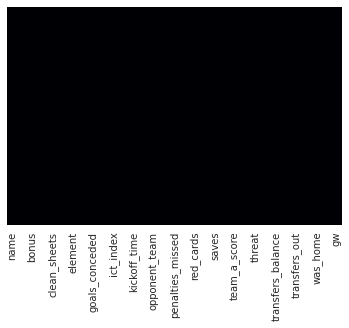

In [6]:
# cheking for null values
sns.set_style('dark')
sns.heatmap(gws.isnull(),yticklabels=False,cbar=False,cmap='inferno')

**Assigning id to each specific player**

In [7]:
#assigning id to each specific player
gws = gws.assign(id=(gws['name']).astype('category').cat.codes)


In [8]:
gws= gws[gws['minutes'] > 0] 


**A function to decide the fixture difficulty ratio based on the position of the opponent team**

In [9]:
# a function to decide the fixture difficulty ratio based on the position of the opponent team
def fd(x):
  x=int(x)
  if x<=6:
    return '3'
  elif x>6 and x<=14:
    return '1'
  else:
    return '2'

In [10]:
gws.rename(columns={'opponent_team':'fdr'},inplace=True)


In [11]:
gws['fdr']=gws['fdr'].apply(fd).astype(float)


In [12]:
gws['kickoff_time']=pd.to_datetime(gws['kickoff_time'])

In [13]:
gws['kickoff_time'] = gws.kickoff_time.dt.hour


**Divided the kickoff time into 3 categories**



In [14]:
#divind the kickoff time into 3 categories 
def time(x):
  x=int(x)
  if x>8 and x<=12:
    return '0'
  elif x>12 and x<=18:
    return '1'
  else:
    return '2'

In [15]:
gws['kickoff_time']=gws['kickoff_time'].apply(time).astype(float)
gws.head(20)


,name,assists,bonus,bps,clean_sheets,creativity,element,fixture,goals_conceded,goals_scored,ict_index,influence,kickoff_time,minutes,fdr,own_goals,penalties_missed,penalties_saved,red_cards,round,saves,selected,team_a_score,team_h_score,threat,total_points,transfers_balance,transfers_in,transfers_out,value,was_home,yellow_cards,gw,id
1,Aaron Lennon,0,0,6,1,12.3,83,8,0,0,3.9,10.0,0.0,90,2.0,0,0,0,0,1,0,15138,0,0,17.0,3,0,0,0,50,FALSE,0,77,2
2,Aaron Mooy,0,0,24,0,18.2,199,4,3,0,3.8,20.2,1.0,90,3.0,0,0,0,0,1,0,192110,3,0,0.0,2,0,0,0,55,TRUE,0,77,3
3,Aaron Ramsey,0,0,7,0,10.8,14,1,1,0,2.9,9.4,1.0,53,1.0,0,0,0,0,1,0,60423,2,0,9.0,1,0,0,0,75,TRUE,0,77,5
4,Aaron Wan-Bissaka,1,3,38,1,14.0,145,3,0,0,6.0,46.0,1.0,90,1.0,0,0,0,0,1,0,652304,2,0,0.0,12,0,0,0,40,FALSE,0,77,7
6,Abdoulaye Doucour�,0,0,16,1,25.8,390,9,0,0,3.9,11.6,1.0,90,3.0,0,0,0,0,1,0,108189,0,2,2.0,3,0,0,0,60,TRUE,0,77,11
7,Aboubakar Kamara,0,0,2,0,25.6,189,3,1,0,5.4,6.2,1.0,29,1.0,0,0,0,0,1,0,499362,2,0,22.0,1,0,0,0,45,TRUE,0,77,12
8,Adama Diakhaby,0,0,2,0,0.3,471,4,1,0,0.5,4.2,1.0,19,3.0,0,0,0,0,1,0,2723,3,0,0.0,1,0,0,0,50,TRUE,0,77,20
12,Adam Smith,0,0,25,1,15.5,29,2,0,0,3.2,16.2,1.0,90,3.0,0,0,0,0,1,0,21187,0,2,0.0,6,0,0,0,45,TRUE,0,77,18
15,Adrien Sebastian Perruchet Silva,0,0,13,0,6.2,231,6,1,0,1.7,10.8,2.0,79,1.0,0,0,0,0,1,0,10282,1,2,0.0,2,0,0,0,50,FALSE,0,77,26
17,Ainsley Maitland-Niles,0,0,7,0,10.3,20,1,1,0,2.1,10.8,1.0,34,1.0,0,0,0,0,1,0,31526,2,0,0.0,1,0,0,0,45,TRUE,0,77,30


**Setting up the 'was_home' column to create binary attributes**


In [16]:
# setting up the 'was_home' column to create binary attributes
def was_home(a):
  a=a.upper()
  if a=="FALSE":
    #print('Away')
    return str('Away')
  else:
    #print('Home')
    return str('Home')

In [17]:
gws['home']=gws['was_home'].apply(was_home)

**Feature engineered variables based on Home and away performances of a player for further analysis**

In [18]:
gws['Away Points'] = np.where(gws['home'] == 'Home', gws['total_points'] * 0,gws['total_points'])
gws['Home Points'] = np.where(gws['home'] == 'Away', gws['total_points'] * 0,gws['total_points'])

gws['Away Influence'] = np.where(gws['home'] == 'Home', gws['influence'] * 0,gws['influence'])
gws['Home Influence'] = np.where(gws['home'] == 'Away', gws['influence'] * 0,gws['influence'])

gws['Away Goals'] = np.where(gws['home'] == 'Home', gws['goals_scored'] * 0,gws['goals_scored'])
gws['Home Goals'] = np.where(gws['home'] == 'Away', gws['goals_scored'] * 0,gws['goals_scored'])

gws['Away Saves'] = np.where(gws['home'] == 'Home', gws['saves'] * 0,gws['saves'])
gws['Home Saves'] = np.where(gws['home'] == 'Away', gws['saves'] * 0,gws['saves'])

gws['Away Creativity'] = np.where(gws['home'] == 'Home', gws['creativity'] * 0,gws['creativity'])
gws['Home Creativity'] = np.where(gws['home'] == 'Away', gws['creativity'] * 0,gws['creativity'])

gws['Away ICT'] = np.where(gws['home'] == 'Home', gws['ict_index'] * 0,gws['ict_index'])
gws['Home ICT'] = np.where(gws['home'] == 'Away', gws['ict_index'] * 0,gws['ict_index'])

gws['Away Bonus'] = np.where(gws['home'] == 'Home', gws['bonus'] * 0,gws['bonus'])
gws['Home Bonus'] = np.where(gws['home'] == 'Away', gws['bonus'] * 0,gws['bonus'])

gws['Away Clean Sheets'] = np.where(gws['home'] == 'Home', gws['clean_sheets'] * 0,gws['clean_sheets'])
gws['Home Clean Sheets'] = np.where(gws['home'] == 'Away', gws['clean_sheets'] * 0,gws['clean_sheets'])

gws['Away Penalties Saved'] = np.where(gws['home'] == 'Home', gws['penalties_saved'] * 0,gws['penalties_saved'])
gws['Home Penalties Saved'] = np.where(gws['home'] == 'Away', gws['penalties_saved'] * 0,gws['penalties_saved'])

gws['Away Goals Conceded'] = np.where(gws['home'] == 'Home', gws['goals_conceded'] * 0,gws['goals_conceded'])
gws['Home Goals Conceded'] = np.where(gws['home'] == 'Away', gws['goals_conceded'] * 0,gws['goals_conceded'])

gws['Away Assists'] = np.where(gws['home'] == 'Home', gws['assists'] * 0,gws['assists'])
gws['Home Assists'] = np.where(gws['home'] == 'Away', gws['assists'] * 0,gws['assists'])

gws.head(20)


,name,assists,bonus,bps,clean_sheets,creativity,element,fixture,goals_conceded,goals_scored,ict_index,influence,kickoff_time,minutes,fdr,own_goals,penalties_missed,penalties_saved,red_cards,round,saves,selected,team_a_score,team_h_score,threat,total_points,transfers_balance,transfers_in,transfers_out,value,was_home,yellow_cards,gw,id,home,Away Points,Home Points,Away Influence,Home Influence,Away Goals,Home Goals,Away Saves,Home Saves,Away Creativity,Home Creativity,Away ICT,Home ICT,Away Bonus,Home Bonus,Away Clean Sheets,Home Clean Sheets,Away Penalties Saved,Home Penalties Saved,Away Goals Conceded,Home Goals Conceded,Away Assists,Home Assists
1,Aaron Lennon,0,0,6,1,12.3,83,8,0,0,3.9,10.0,0.0,90,2.0,0,0,0,0,1,0,15138,0,0,17.0,3,0,0,0,50,FALSE,0,77,2,Away,3,0,10.0,0.0,0,0,0,0,12.3,0.0,3.9,0.0,0,0,1,0,0,0,0,0,0,0
2,Aaron Mooy,0,0,24,0,18.2,199,4,3,0,3.8,20.2,1.0,90,3.0,0,0,0,0,1,0,192110,3,0,0.0,2,0,0,0,55,TRUE,0,77,3,Home,0,2,0.0,20.2,0,0,0,0,0.0,18.2,0.0,3.8,0,0,0,0,0,0,0,3,0,0
3,Aaron Ramsey,0,0,7,0,10.8,14,1,1,0,2.9,9.4,1.0,53,1.0,0,0,0,0,1,0,60423,2,0,9.0,1,0,0,0,75,TRUE,0,77,5,Home,0,1,0.0,9.4,0,0,0,0,0.0,10.8,0.0,2.9,0,0,0,0,0,0,0,1,0,0
4,Aaron Wan-Bissaka,1,3,38,1,14.0,145,3,0,0,6.0,46.0,1.0,90,1.0,0,0,0,0,1,0,652304,2,0,0.0,12,0,0,0,40,FALSE,0,77,7,Away,12,0,46.0,0.0,0,0,0,0,14.0,0.0,6.0,0.0,3,0,1,0,0,0,0,0,1,0
6,Abdoulaye Doucour�,0,0,16,1,25.8,390,9,0,0,3.9,11.6,1.0,90,3.0,0,0,0,0,1,0,108189,0,2,2.0,3,0,0,0,60,TRUE,0,77,11,Home,0,3,0.0,11.6,0,0,0,0,0.0,25.8,0.0,3.9,0,0,0,1,0,0,0,0,0,0
7,Aboubakar Kamara,0,0,2,0,25.6,189,3,1,0,5.4,6.2,1.0,29,1.0,0,0,0,0,1,0,499362,2,0,22.0,1,0,0,0,45,TRUE,0,77,12,Home,0,1,0.0,6.2,0,0,0,0,0.0,25.6,0.0,5.4,0,0,0,0,0,0,0,1,0,0
8,Adama Diakhaby,0,0,2,0,0.3,471,4,1,0,0.5,4.2,1.0,19,3.0,0,0,0,0,1,0,2723,3,0,0.0,1,0,0,0,50,TRUE,0,77,20,Home,0,1,0.0,4.2,0,0,0,0,0.0,0.3,0.0,0.5,0,0,0,0,0,0,0,1,0,0
12,Adam Smith,0,0,25,1,15.5,29,2,0,0,3.2,16.2,1.0,90,3.0,0,0,0,0,1,0,21187,0,2,0.0,6,0,0,0,45,TRUE,0,77,18,Home,0,6,0.0,16.2,0,0,0,0,0.0,15.5,0.0,3.2,0,0,0,1,0,0,0,0,0,0
15,Adrien Sebastian Perruchet Silva,0,0,13,0,6.2,231,6,1,0,1.7,10.8,2.0,79,1.0,0,0,0,0,1,0,10282,1,2,0.0,2,0,0,0,50,FALSE,0,77,26,Away,2,0,10.8,0.0,0,0,0,0,6.2,0.0,1.7,0.0,0,0,0,0,0,0,1,0,0,0
17,Ainsley Maitland-Niles,0,0,7,0,10.3,20,1,1,0,2.1,10.8,1.0,34,1.0,0,0,0,0,1,0,31526,2,0,0.0,1,0,0,0,45,TRUE,0,77,30,Home,0,1,0.0,10.8,0,0,0,0,0.0,10.3,0.0,2.1,0,0,0,0,0,0,0,1,0,0


**Dropping columns that are not required**


In [19]:
#dropping columns that are not required
gws.drop(['element','fixture','round','transfers_balance','transfers_in','transfers_out','team_a_score','was_home',	'team_h_score','round'],axis=1, inplace=True)

In [20]:
gws['value']=gws['value']*0.1



**A fucntion to put the points into the bins. This is where the business problem is convereted from a regression to a classification problem**


In [21]:
# a fucntion to put the points into the bins. This is where the business problem is convereted from a regression to a classification problem
def points(x):
  if x<8:
    return 0
  # elif x==2:
  #   return 2
  # elif x>2 and x<7:
  #   return 3
  else:
    return 1


In [22]:
gws['points']=gws['total_points'].apply(points)
gws1=gws.copy()
gws1.head()

,name,assists,bonus,bps,clean_sheets,creativity,goals_conceded,goals_scored,ict_index,influence,kickoff_time,minutes,fdr,own_goals,penalties_missed,penalties_saved,red_cards,saves,selected,threat,total_points,value,yellow_cards,gw,id,home,Away Points,Home Points,Away Influence,Home Influence,Away Goals,Home Goals,Away Saves,Home Saves,Away Creativity,Home Creativity,Away ICT,Home ICT,Away Bonus,Home Bonus,Away Clean Sheets,Home Clean Sheets,Away Penalties Saved,Home Penalties Saved,Away Goals Conceded,Home Goals Conceded,Away Assists,Home Assists,points
1,Aaron Lennon,0,0,6,1,12.3,0,0,3.9,10.0,0.0,90,2.0,0,0,0,0,0,15138,17.0,3,5.0,0,77,2,Away,3,0,10.0,0.0,0,0,0,0,12.3,0.0,3.9,0.0,0,0,1,0,0,0,0,0,0,0,0
2,Aaron Mooy,0,0,24,0,18.2,3,0,3.8,20.2,1.0,90,3.0,0,0,0,0,0,192110,0.0,2,5.5,0,77,3,Home,0,2,0.0,20.2,0,0,0,0,0.0,18.2,0.0,3.8,0,0,0,0,0,0,0,3,0,0,0
3,Aaron Ramsey,0,0,7,0,10.8,1,0,2.9,9.4,1.0,53,1.0,0,0,0,0,0,60423,9.0,1,7.5,0,77,5,Home,0,1,0.0,9.4,0,0,0,0,0.0,10.8,0.0,2.9,0,0,0,0,0,0,0,1,0,0,0
4,Aaron Wan-Bissaka,1,3,38,1,14.0,0,0,6.0,46.0,1.0,90,1.0,0,0,0,0,0,652304,0.0,12,4.0,0,77,7,Away,12,0,46.0,0.0,0,0,0,0,14.0,0.0,6.0,0.0,3,0,1,0,0,0,0,0,1,0,1
6,Abdoulaye Doucour�,0,0,16,1,25.8,0,0,3.9,11.6,1.0,90,3.0,0,0,0,0,0,108189,2.0,3,6.0,0,77,11,Home,0,3,0.0,11.6,0,0,0,0,0.0,25.8,0.0,3.9,0,0,0,1,0,0,0,0,0,0,0


In [23]:
# point=pd.get_dummies(gws1['points'])
# gws1=pd.concat([gws1,point],axis=1)
# gws1.head()

**Distribution of each class of the dependent variable**

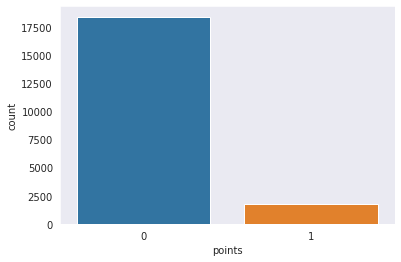

In [24]:
sns.countplot(gws1['points'])

**Creating lags for different attributes**


In [25]:
#creating lags for different attributes

gws1['Last_Week_Points'] = gws1.groupby(['id'])['total_points'].shift().astype(float)
# gws1['Last_2_Week_Points'] = gws1.groupby(['id'])['total_points'].shift(2).astype(float)
#gws1['Last_3_Week_Points'] = gws1.groupby(['id'])['total_points'].shift(3).astype(float)
#gws1['Last_4_Week_Points'] = gws1.groupby(['id'])['total_points'].shift(4).astype(float)



gws1['Last_Week_Goals'] = gws1.groupby(['id'])['goals_scored'].shift().astype(float)
# gws1['Last_2_Week_Goals'] = gws1.groupby(['id'])['goals_scored'].shift(2).astype(float)
#gws1['Last_3_Week_Goals'] = gws1.groupby(['id'])['goals_scored'].shift(3).astype(float)


gws1['Last_Week_ICT'] = gws1.groupby(['id'])['ict_index'].shift().astype(float)
# gws1['Last_2_Week_ICT'] = gws1.groupby(['id'])['ict_index'].shift(2).astype(float)
# #gws1['Last_3_Week_ICT'] = gws1.groupby(['id'])['ict_index'].shift(3).astype(float)


gws1['Last_Week_BPS'] = gws1.groupby(['id'])['bps'].shift().astype(float)
# gws1['Last_2_Week_BPS'] = gws1.groupby(['id'])['bps'].shift(2).astype(float)
#gws1['Last_3_Week_BPS'] = gws1.groupby(['id'])['bps'].shift(3).astype(float)


gws1['Last_Week_Assists'] = gws1.groupby(['id'])['assists'].shift().astype(float)
# gws1['Last_2_Week_Assists'] = gws1.groupby(['id'])['assists'].shift(2).astype(float)
#gws1['Last_3_Week_Assists'] = gws1.groupby(['id'])['assists'].shift(3).astype(float)


gws1['Last_Week_Bonus'] = gws1.groupby(['id'])['bonus'].shift().astype(float)
# gws1['Last_2_Week_Bonus'] = gws1.groupby(['id'])['bonus'].shift(2).astype(float)
#gws1['Last_3_Week_Bonus'] = gws1.groupby(['id'])['bonus'].shift(3).astype(float)


gws1['Last_Week_Influence'] = gws1.groupby(['id'])['influence'].shift().astype(float)
# gws1['Last_2_Week_Influence'] = gws1.groupby(['id'])['influence'].shift(2).astype(float)
#gws1['Last_3_Week_Influence'] = gws1.groupby(['id'])['influence'].shift(3).astype(float)


gws1['Last_Week_Minutes_Played'] = gws1.groupby(['id'])['minutes'].shift().astype(float)
# gws1['Last_2_Week_Minutes_Played'] = gws1.groupby(['id'])['minutes'].shift(2).astype(float)
#gws1['Last_3_Week_Minutes_Played'] = gws1.groupby(['id'])['minutes'].shift(3).astype(float)


gws1['Last_Week_Threat'] = gws1.groupby(['id'])['threat'].shift().astype(float)
# gws1['Last_2_Week_Threat'] = gws1.groupby(['id'])['threat'].shift(2).astype(float)
# #gws1['Last_3_Week_Threat'] = gws1.groupby(['id'])['threat'].shift(3).astype(float)


gws1['Last_Week_Selected'] = gws1.groupby(['id'])['selected'].shift().astype(float)
# gws1['Last_2_Week_Selected'] = gws1.groupby(['id'])['selected'].shift(2).astype(float)
#gws1['Last_3_Week_Selected'] = gws1.groupby(['id'])['selected'].shift(3).astype(float)


gws1['Last_Week_Value'] = gws1.groupby(['id'])['value'].shift().astype(float)
# gws1['Last_2_Week_Value'] = gws1.groupby(['id'])['value'].shift(2).astype(float)
# gws1['Last_3_Week_Value'] = gws1.groupby(['id'])['value'].shift(3).astype(float)


gws1['Last_Week_Creativity'] = gws1.groupby(['id'])['creativity'].shift().astype(float)
# gws1['Last_2_Week_Creativity'] = gws1.groupby(['id'])['creativity'].shift(2).astype(float)
# #gws1['Last_3_Week_Creativity'] = gws1.groupby(['id'])['creativity'].shift(3).astype(float)



gws1['Last_Week_FDR'] = gws1.groupby(['id'])['fdr'].shift().astype(float).astype(float)
# gws1['Last_2_Week_FDR'] = gws1.groupby(['id'])['fdr'].shift(2).astype(float).astype(float)
# gws1['Last_3_Week_FDR'] = gws1.groupby(['id'])['fdr'].shift(3).astype(float).astype(float)


gws1['Last_Week_Clean_Sheets'] = gws1.groupby(['id'])['clean_sheets'].shift().astype(float)
# gws1['Last_2_Week_Clean_Sheets'] = gws1.groupby(['id'])['clean_sheets'].shift(2).astype(float)
#gws1['Last_3_Week_Clean_Sheets'] = gws1.groupby(['id'])['clean_sheets'].shift(3).astype(float)


gws1['Last_Week_Goals_Conceded'] = gws1.groupby(['id'])['goals_conceded'].shift().astype(float)
# gws1['Last_2_Week_Goals_Conceded'] = gws1.groupby(['id'])['goals_conceded'].shift(2).astype(float)
#gws1['Last_3_Week_Goals_Conceded'] = gws1.groupby(['id'])['goals_conceded'].shift(3).astype(float)


# gws1['Last_Week_Kickoff_Time'] = gws1.groupby(['id'])['kickoff_time'].shift().astype(float)
# gws1['Last_2_Week_Kickoff_Time'] = gws1.groupby(['id'])['kickoff_time'].shift(2).astype(float)
# gws1['Last_3_Week_Kickoff_Time'] = gws1.groupby(['id'])['kickoff_time'].shift(3).astype(float)


gws1['Last_Week_Own_Goals'] = gws1.groupby(['id'])['own_goals'].shift().astype(float)
# gws1['Last_2_Week_Own_Goals'] = gws1.groupby(['id'])['own_goals'].shift(2).astype(float)
# gws1['Last_3_Week_Own_Goals'] = gws1.groupby(['id'])['own_goals'].shift(3).astype(float)


gws1['Last_Week_Penalties_Missed'] = gws1.groupby(['id'])['penalties_missed'].shift().astype(float)
# gws1['Last_2_Week_Penalties_Missed'] = gws1.groupby(['id'])['penalties_missed'].shift(2).astype(float)
# gws1['Last_3_Week_Penalties_Saved'] = gws1.groupby(['id'])['penalties_saved'].shift(3).astype(float)


gws1['Last_Week_Penalties_Saved'] = gws1.groupby(['id'])['penalties_saved'].shift().astype(float)
# gws1['Last_2_Week_Penalties_Saved'] = gws1.groupby(['id'])['penalties_saved'].shift(2).astype(float)


gws1['Last_Week_Red_Cards'] = gws1.groupby(['id'])['red_cards'].shift().astype(float)
# gws1['Last_2_Week_Red_Cards'] = gws1.groupby(['id'])['red_cards'].shift(2).astype(float)
# gws1['Last_3_Week_Red_Cards'] = gws1.groupby(['id'])['red_cards'].shift(3).astype(float)


gws1['Last_Week_Saves'] = gws1.groupby(['id'])['saves'].shift().astype(float)
# gws1['Last_2_Week_Saves'] = gws1.groupby(['id'])['saves'].shift(2)
#gws1['Last_3_Week_Saves'] = gws1.groupby(['id'])['saves'].shift(3)


gws1['Last_Week_Yellow_Cards'] = gws1.groupby(['id'])['yellow_cards'].shift().astype(float)
# gws1['Last_2_Week_Yellow_Cards'] = gws1.groupby(['id'])['yellow_cards'].shift(2)
# gws1['Last_3_Week_Yellow_Cards'] = gws1.groupby(['id'])['yellow_cards'].shift(3)


# gws1['Last_Week_Home'] = gws1.groupby(['id'])['home'].shift()
# gws1['Last_2_Week_Home'] = gws1.groupby(['id'])['home'].shift(2)
# gws1['Last_3_Week_Home'] = gws1.groupby(['id'])['home'].shift(3)


gws1.head(100)


,name,assists,bonus,bps,clean_sheets,creativity,goals_conceded,goals_scored,ict_index,influence,kickoff_time,minutes,fdr,own_goals,penalties_missed,penalties_saved,red_cards,saves,selected,threat,total_points,value,yellow_cards,gw,id,home,Away Points,Home Points,Away Influence,Home Influence,Away Goals,Home Goals,Away Saves,Home Saves,Away Creativity,Home Creativity,Away ICT,Home ICT,Away Bonus,Home Bonus,Away Clean Sheets,Home Clean Sheets,Away Penalties Saved,Home Penalties Saved,Away Goals Conceded,Home Goals Conceded,Away Assists,Home Assists,points,Last_Week_Points,Last_Week_Goals,Last_Week_ICT,Last_Week_BPS,Last_Week_Assists,Last_Week_Bonus,Last_Week_Influence,Last_Week_Minutes_Played,Last_Week_Threat,Last_Week_Selected,Last_Week_Value,Last_Week_Creativity,Last_Week_FDR,Last_Week_Clean_Sheets,Last_Week_Goals_Conceded,Last_Week_Own_Goals,Last_Week_Penalties_Missed,Last_Week_Penalties_Saved,Last_Week_Red_Cards,Last_Week_Saves,Last_Week_Yellow_Cards
1,Aaron Lennon,0,0,6,1,12.3,0,0,3.9,10.0,0.0,90,2.0,0,0,0,0,0,15138,17.0,3,5.0,0,77,2,Away,3,0,10.0,0.0,0,0,0,0,12.3,0.0,3.9,0.0,0,0,1,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Aaron Mooy,0,0,24,0,18.2,3,0,3.8,20.2,1.0,90,3.0,0,0,0,0,0,192110,0.0,2,5.5,0,77,3,Home,0,2,0.0,20.2,0,0,0,0,0.0,18.2,0.0,3.8,0,0,0,0,0,0,0,3,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Aaron Ramsey,0,0,7,0,10.8,1,0,2.9,9.4,1.0,53,1.0,0,0,0,0,0,60423,9.0,1,7.5,0,77,5,Home,0,1,0.0,9.4,0,0,0,0,0.0,10.8,0.0,2.9,0,0,0,0,0,0,0,1,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Aaron Wan-Bissaka,1,3,38,1,14.0,0,0,6.0,46.0,1.0,90,1.0,0,0,0,0,0,652304,0.0,12,4.0,0,77,7,Away,12,0,46.0,0.0,0,0,0,0,14.0,0.0,6.0,0.0,3,0,1,0,0,0,0,0,1,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,Abdoulaye Doucour�,0,0,16,1,25.8,0,0,3.9,11.6,1.0,90,3.0,0,0,0,0,0,108189,2.0,3,6.0,0,77,11,Home,0,3,0.0,11.6,0,0,0,0,0.0,25.8,0.0,3.9,0,0,0,1,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
182,Francisco Femen�a Far,0,0,5,0,0.1,0,0,0.2,2.2,1.0,3,3.0,0,0,0,0,0,25857,0.0,1,4.5,0,77,304,Home,0,1,0.0,2.2,0,0,0,0,0.0,0.1,0.0,0.2,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
184,Frederico Rodrigues de Paula Santos,0,0,8,1,5.1,0,0,1.0,4.6,2.0,75,1.0,0,0,0,0,0,232569,0.0,2,6.0,1,77,307,Home,0,2,0.0,4.6,0,0,0,0,0.0,5.1,0.0,1.0,0,0,0,1,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
185,Gabriel Fernando de Jesus,0,0,1,0,0.7,0,0,0.1,0.2,1.0,11,3.0,0,0,0,0,0,121425,0.0,1,10.5,0,77,309,Away,1,0,0.2,0.0,0,0,0,0,0.7,0.0,0.1,0.0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
187,Gary Madine,0,0,5,0,0.0,1,0,0.2,2.0,1.0,2,3.0,0,0,0,0,0,51829,0.0,1,4.5,0,77,312,Away,1,0,2.0,0.0,0,0,0,0,0.0,0.0,0.2,0.0,0,0,0,0,0,0,1,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


**Creating binary attributes for was_home**


In [26]:
#creating binary attributes for was_home

home=pd.get_dummies(gws1['home'])
gws1=pd.concat([gws1,home],axis=1)
gws1.head()


,name,assists,bonus,bps,clean_sheets,creativity,goals_conceded,goals_scored,ict_index,influence,kickoff_time,minutes,fdr,own_goals,penalties_missed,penalties_saved,red_cards,saves,selected,threat,total_points,value,yellow_cards,gw,id,home,Away Points,Home Points,Away Influence,Home Influence,Away Goals,Home Goals,Away Saves,Home Saves,Away Creativity,Home Creativity,Away ICT,Home ICT,Away Bonus,Home Bonus,Away Clean Sheets,Home Clean Sheets,Away Penalties Saved,Home Penalties Saved,Away Goals Conceded,Home Goals Conceded,Away Assists,Home Assists,points,Last_Week_Points,Last_Week_Goals,Last_Week_ICT,Last_Week_BPS,Last_Week_Assists,Last_Week_Bonus,Last_Week_Influence,Last_Week_Minutes_Played,Last_Week_Threat,Last_Week_Selected,Last_Week_Value,Last_Week_Creativity,Last_Week_FDR,Last_Week_Clean_Sheets,Last_Week_Goals_Conceded,Last_Week_Own_Goals,Last_Week_Penalties_Missed,Last_Week_Penalties_Saved,Last_Week_Red_Cards,Last_Week_Saves,Last_Week_Yellow_Cards,Away,Home
1,Aaron Lennon,0,0,6,1,12.3,0,0,3.9,10.0,0.0,90,2.0,0,0,0,0,0,15138,17.0,3,5.0,0,77,2,Away,3,0,10.0,0.0,0,0,0,0,12.3,0.0,3.9,0.0,0,0,1,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0
2,Aaron Mooy,0,0,24,0,18.2,3,0,3.8,20.2,1.0,90,3.0,0,0,0,0,0,192110,0.0,2,5.5,0,77,3,Home,0,2,0.0,20.2,0,0,0,0,0.0,18.2,0.0,3.8,0,0,0,0,0,0,0,3,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1
3,Aaron Ramsey,0,0,7,0,10.8,1,0,2.9,9.4,1.0,53,1.0,0,0,0,0,0,60423,9.0,1,7.5,0,77,5,Home,0,1,0.0,9.4,0,0,0,0,0.0,10.8,0.0,2.9,0,0,0,0,0,0,0,1,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1
4,Aaron Wan-Bissaka,1,3,38,1,14.0,0,0,6.0,46.0,1.0,90,1.0,0,0,0,0,0,652304,0.0,12,4.0,0,77,7,Away,12,0,46.0,0.0,0,0,0,0,14.0,0.0,6.0,0.0,3,0,1,0,0,0,0,0,1,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0
6,Abdoulaye Doucour�,0,0,16,1,25.8,0,0,3.9,11.6,1.0,90,3.0,0,0,0,0,0,108189,2.0,3,6.0,0,77,11,Home,0,3,0.0,11.6,0,0,0,0,0.0,25.8,0.0,3.9,0,0,0,1,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1


**Feature engineered a number of variables to better define the dependent variable**


In [ ]:
#feature engineered a number of variables to better define the dependent variable
window=3

hpm =gws1.groupby('id',as_index=False)['Home Points'].rolling(window=window).sum().shift(1).astype(float)
gws1["Home Points Form"] = hpm.reset_index(level=0, drop=True)

apm =gws1.groupby('id',as_index=False)['Away Points'].rolling(window=window).sum().shift(1).astype(float)
gws1["Away Points Form"] = apm.reset_index(level=0, drop=True)

ppm =(gws1.groupby('id',as_index=False)['total_points'].expanding().sum()/gws1.groupby('id',as_index=False)['minutes'].expanding().sum()*90).astype(float)
gws1["Points_90"] = ppm.reset_index(level=0, drop=True)

vm =(gws1.groupby('id',as_index=False)['value'].expanding().sum()/gws1.groupby('id',as_index=False)['total_points'].expanding().sum()*90).astype(float)
gws1["Value_Point"] = vm.reset_index(level=0, drop=True)

apm =gws1.groupby('id',as_index=False)['assists'].expanding().sum()/gws1.groupby('id',as_index=False)['minutes'].expanding().sum().astype(float)
gws1["Assists per Min"] = apm.reset_index(level=0, drop=True)

gpm =(gws1.groupby('id',as_index=False)['goals_scored'].expanding().sum()/gws1.groupby('id',as_index=False)['minutes'].expanding().sum()*90).astype(float)
gws1["Goals_90"] = gpm.reset_index(level=0, drop=True)

ipm =(gws1.groupby('id',as_index=False)['influence'].expanding().sum()/gws1.groupby('id',as_index=False)['minutes'].expanding().sum()*90).astype(float)
gws1["Influence_90"] = ipm.reset_index(level=0, drop=True)

bpm =(gws1.groupby('id',as_index=False)['bonus'].expanding().sum()/gws1.groupby('id',as_index=False)['minutes'].expanding().sum()*90).astype(float)
gws1["Bonus_90"] = ipm.reset_index(level=0, drop=True)

ih =gws1.groupby('id',as_index=False)['Home Influence'].rolling(window=window).sum().shift(1).astype(float)
gws1["Home Influence Form"] = ih.reset_index(level=0, drop=True)

ah =gws1.groupby('id',as_index=False)['Away Influence'].rolling(window=window).sum().shift(1).astype(float)
gws1["Away Influence Form"] = ah.reset_index(level=0, drop=True)

hg =gws1.groupby('id',as_index=False)['Home Goals'].rolling(window=window).sum().shift(1).astype(float)
gws1["Home Goals Form"] = hg.reset_index(level=0, drop=True)

ag =gws1.groupby('id',as_index=False)['Away Goals'].rolling(window=window).sum().shift(1).astype(float)
gws1["Away Goals Form"] = hg.reset_index(level=0, drop=True)


gs =gws1.groupby('id',as_index=False)['goals_scored'].rolling(window=window).sum().shift(1).astype(float)
gws1["Goals Form"] = gs.reset_index(level=0, drop=True)

ag =gws1.groupby('id',as_index=False)['clean_sheets'].expanding().sum()/gws1.groupby('id',as_index=False)['minutes'].expanding().sum().astype(float)
gws1["Clean Sheets per Min"] = ag.reset_index(level=0, drop=True)

cs =gws1.groupby('id',as_index=False)['total_points'].expanding().sum()/gws1.groupby('id',as_index=False)['minutes'].expanding().sum().astype(float)
gws1["Points Per Min"] = cs.reset_index(level=0, drop=True)

gc =gws1.groupby('id',as_index=False)['goals_conceded'].expanding().sum()/gws1.groupby('id',as_index=False)['minutes'].expanding().sum().astype(float)
gws1["Goals Conceded Per Min"] = gc.reset_index(level=0, drop=True)

s =gws1.groupby('id',as_index=False)['saves'].expanding().sum()/gws1.groupby('id',as_index=False)['minutes'].expanding().sum().astype(float)
gws1["Save per min"] = s.reset_index(level=0, drop=True)

sh =gws1.groupby('id',as_index=False)['Home Saves'].rolling(window=window).sum().shift(1).astype(float)
gws1["Home Saves Form"] = sh.reset_index(level=0, drop=True)

sa =gws1.groupby('id',as_index=False)['Away Saves'].rolling(window=window).sum().shift(1).astype(float)
gws1["Away Saves Form"] = sa.reset_index(level=0, drop=True)

sf =gws1.groupby('id',as_index=False)['saves'].rolling(window=window).sum().shift(1).astype(float)
gws1["Saves Form"] = sf.reset_index(level=0, drop=True)

mp =gws1.groupby('id',as_index=False)['minutes'].rolling(window=window).sum().shift(1).astype(float)
gws1["Minutes Form"] = mp.reset_index(level=0, drop=True)

ch =gws1.groupby('id',as_index=False)['Home Creativity'].rolling(window=window).sum().shift(1).astype(float)
gws1["Home Creativity Form"] = ch.reset_index(level=0, drop=True)

ca =gws1.groupby('id',as_index=False)['Away Creativity'].rolling(window=window).sum().shift(1).astype(float)
gws1["Away Creativity Form"] = ca.reset_index(level=0, drop=True)

csh =gws1.groupby('id',as_index=False)['Home Clean Sheets'].rolling(window=window).sum().shift(1).astype(float)
gws1[" Home Clean Sheets Form"] = csh.reset_index(level=0, drop=True)

csa =gws1.groupby('id',as_index=False)['Away Clean Sheets'].rolling(window=window).sum().shift(1).astype(float)
gws1["Away Clean Sheets Form"] = csa.reset_index(level=0, drop=True)

cs =gws1.groupby('id',as_index=False)['clean_sheets'].rolling(window=window).sum().shift(1).astype(float)
gws1["Clean Sheets Form"] = cs.reset_index(level=0, drop=True)

bph =gws1.groupby('id',as_index=False)['Home Bonus'].rolling(window=window).sum().shift(1).astype(float)
gws1['Home Bonus Form'] = bph.reset_index(level=0, drop=True)

bp =gws1.groupby('id',as_index=False)['bonus'].rolling(window=window).sum().shift(1).astype(float)
gws1['Bonus Form'] = bp.reset_index(level=0, drop=True)

bpa =gws1.groupby('id',as_index=False)['Away Bonus'].rolling(window=window).sum().shift(1).astype(float)
gws1["Away Bonus Form"] = bpa.reset_index(level=0, drop=True)

icth =gws1.groupby('id',as_index=False)['Home ICT'].rolling(window=window).sum().shift(1).astype(float)
gws1['Home ICT Form'] = icth.reset_index(level=0, drop=True)

icta =gws1.groupby('id',as_index=False)['Away ICT'].rolling(window=window).sum().shift(1).astype(float)
gws1["Away ICT Form"] = icta.reset_index(level=0, drop=True)


ict =gws1.groupby('id',as_index=False)['ict_index'].rolling(window=window).sum().shift(1).astype(float)
gws1["ICT Form"] = ict.reset_index(level=0, drop=True)

ah =gws1.groupby('id',as_index=False)['Home Assists'].rolling(window=window).sum().shift(1).astype(float)
gws1['Home Assists Form'] = ah.reset_index(level=0, drop=True)

aa =gws1.groupby('id',as_index=False)['Away Assists'].rolling(window=window).sum().shift(1).astype(float)
gws1["Away Assists Form"] = aa.reset_index(level=0, drop=True)

ast =gws1.groupby('id',as_index=False)['assists'].rolling(window=window).sum().shift(1).astype(float)
gws1["Assists Form"] = ast.reset_index(level=0, drop=True)

# ms =gws1.groupby('id',as_index=False)['minutes'+0.0000001].expanding().sum()/gws1.groupby('id',as_index=False)['saves'+0.0000001].expanding().sum()
# gws1["Mins Per Save"] = ms.reset_index(level=0, drop=True)

bpss =gws1.groupby('id',as_index=False)['minutes'].expanding().sum()/gws1.groupby('id',as_index=False)['bps'].expanding().sum().astype(float)
gws1["Mins Per BPS"] = bpss.reset_index(level=0, drop=True)

gca =gws1.groupby('id',as_index=False)['Away Goals Conceded'].rolling(window=window).sum().shift(1).astype(float)
gws1["Away Goals Concecded Form"] = gca.reset_index(level=0, drop=True)

gch =gws1.groupby('id',as_index=False)['Home Goals Conceded'].rolling(window=window).sum().shift(1).astype(float)
gws1["Goals Conceded Home"] = gch.reset_index(level=0, drop=True)

gc =gws1.groupby('id',as_index=False)['goals_conceded'].rolling(window=window).sum().shift(1).astype(float)
gws1["Goals Conceded Form"] = gc.reset_index(level=0, drop=True)

gcm =gws1.groupby('id',as_index=False)['minutes'].expanding().sum()/gws1.groupby('id',as_index=False)['goals_conceded'].expanding().sum().astype(float)
gws1["Mins per Goals Conceded"] = gcm.reset_index(level=0, drop=True)

tp =gws1.groupby('id',as_index=False)['total_points'].rolling(window=window).sum().shift(1).astype(float)
gws1["Points Form"] = tp.reset_index(level=0, drop=True)

pm =gws1.groupby('id',as_index=False)['penalties_missed'].rolling(window=window).sum().shift(1).astype(float)
gws1["Penalties Missed Form"] = pm.reset_index(level=0, drop=True)

yc =gws1.groupby('id',as_index=False)['yellow_cards'].rolling(window=window).sum().shift(1).astype(float)
gws1["Yellow Cards Form"] = yc.reset_index(level=0, drop=True)

rc =gws1.groupby('id',as_index=False)['red_cards'].rolling(window=window).sum().shift(1).astype(float)
gws1["Red Cards Form"] = rc.reset_index(level=0, drop=True)



In [ ]:
# gws1['dummy1']=gws1['goals_scored']
# gws1['dummy2']=gws1['clean_sheets']


**A function to capture the goal scoring streak of a player**





In [ ]:
# a function to capture the goal scoring streak of a player
def f(df):
    df['Goalstreak'] = (df['goals_scored'] > 0).cumsum()
    df['cumsum'] = np.nan
    df.loc[df['goals_scored'] == 0, 'cumsum'] = df['Goalstreak']
    df['cumsum'] = df['cumsum'].fillna(method='ffill')
    df['cumsum'] = df['cumsum'].fillna(0)
    df['Goal Streak'] = df['Goalstreak'] - df['cumsum']
    df.drop(['Goalstreak', 'cumsum'], axis=1, inplace=True)
    df['Goal Streak']=df['Goal Streak'].shift(1)
    return df


In [ ]:
gws1=gws1.groupby('id').apply(f)


**A function to capture the clean sheet streak of a player**



In [ ]:
def f2(df):
    df['csstreak'] = (df['clean_sheets'] > 0).cumsum()
    df['cumsum'] = np.nan
    df.loc[df['clean_sheets'] == 0, 'cumsum'] = df['csstreak']
    df['cumsum'] = df['cumsum'].fillna(method='ffill')
    df['cumsum'] = df['cumsum'].fillna(0)
    df['Clean Sheet Streak'] = df['csstreak'] - df['cumsum']
    df.drop(['csstreak', 'cumsum'], axis=1, inplace=True)
    df['Clean Sheet Streak']=df['Clean Sheet Streak'].shift(1)
    return df


In [ ]:
gws1=gws1.groupby('id').apply(f2)

**A function to capture the penalty Saving streak of a player**



In [ ]:
def f3(df):
    df['psstreak'] = (df['penalties_saved'] > 0).cumsum()
    df['cumsum'] = np.nan
    df.loc[df['penalties_saved'] == 0, 'cumsum'] = df['psstreak']
    df['cumsum'] = df['cumsum'].fillna(method='ffill')
    df['cumsum'] = df['cumsum'].fillna(0)
    df['Penalty Save Streak'] = df['psstreak'] - df['cumsum']
    df.drop(['psstreak', 'cumsum'], axis=1, inplace=True)
    df['Penalty Save Streak']=df['Penalty Save Streak'].shift(1)
    return df

In [ ]:
gws1=gws1.groupby('id').apply(f3)
gws1.fillna()

In [177]:
gws1.to_csv('/content/drive/My Drive/pre1.csv')

**Dropping all the NAn, inf values created because of feature engineering**


In [178]:
#dropping all the NAn, inf values created because of feature engineering
gws1=gws1.replace([np.inf, -np.inf], np.nan)

gws1=gws1.dropna()
gws1.head(200)


,name,assists,bonus,bps,clean_sheets,creativity,goals_conceded,goals_scored,ict_index,influence,kickoff_time,minutes,fdr,own_goals,penalties_missed,penalties_saved,red_cards,saves,selected,threat,total_points,value,yellow_cards,gw,id,home,Away Points,Home Points,Away Influence,Home Influence,Away Goals,Home Goals,Away Saves,Home Saves,Away Creativity,Home Creativity,Away ICT,Home ICT,Away Bonus,Home Bonus,...,Bonus_90,Home Influence Form,Away Influence Form,Home Goals Form,Away Goals Form,Goals Form,Clean Sheets per Min,Points Per Min,Goals Conceded Per Min,Save per min,Home Saves Form,Away Saves Form,Saves Form,Minutes Form,Home Creativity Form,Away Creativity Form,Home Clean Sheets Form,Away Clean Sheets Form,Clean Sheets Form,Home Bonus Form,Bonus Form,Away Bonus Form,Home ICT Form,Away ICT Form,ICT Form,Home Assists Form,Away Assists Form,Assists Form,Mins Per BPS,Away Goals Concecded Form,Goals Conceded Home,Goals Conceded Form,Mins per Goals Conceded,Points Form,Penalties Missed Form,Yellow Cards Form,Red Cards Form,Goal Streak,Clean Sheet Streak,Penalty Save Streak
1584,Aaron Lennon,0,0,2,0,2.5,2,0,0.8,0.0,1.0,90,1.0,0,0,0,0,0,19862,6.0,2,5.0,0,80,2,Home,0,2,0.0,0.0,0,0,0,0,0.0,2.5,0.0,0.8,0,0,...,4.850000,5.6,13.8,0.0,0.0,0.0,0.002778,0.025000,0.025000,0.000000,0.0,0.0,0.0,270.0,2.3,23.7,0.0,1.0,1.0,0.0,0.0,0.0,1.4,5.8,7.2,0.0,0.0,0.0,22.500000,4.0,3.0,7.0,40.000000,7.0,0.0,0.0,0.0,0.0,0.0,0.0
1586,Aaron Ramsey,0,0,15,0,52.2,2,0,12.8,27.4,0.0,90,3.0,0,0,0,0,0,61047,48.0,2,7.4,0,80,5,Away,2,0,27.4,0.0,0,0,0,0,52.2,0.0,12.8,0.0,0,0,...,19.835294,26.4,2.4,0.0,0.0,0.0,0.000000,0.023529,0.019608,0.000000,0.0,0.0,0.0,165.0,42.6,4.8,0.0,0.0,0.0,0.0,0.0,0.0,11.7,2.7,14.4,0.0,0.0,0.0,6.538462,1.0,2.0,3.0,51.000000,4.0,0.0,0.0,0.0,0.0,0.0,0.0
1589,Abdoulaye Doucour�,0,0,9,0,2.2,1,0,0.8,3.4,1.0,90,2.0,1,0,0,0,0,93812,2.0,0,6.0,0,80,11,Home,0,0,0.0,3.4,0,0,0,0,0.0,2.2,0.0,0.8,0,0,...,14.250000,21.6,32.0,0.0,0.0,0.0,0.002778,0.030556,0.008333,0.000000,0.0,0.0,0.0,270.0,63.1,18.1,1.0,0.0,1.0,0.0,1.0,1.0,10.2,5.2,15.4,0.0,1.0,1.0,5.625000,1.0,1.0,2.0,120.000000,11.0,0.0,0.0,0.0,0.0,0.0,0.0
1591,Adama Diakhaby,0,0,4,0,0.6,1,0,0.6,3.6,1.0,59,1.0,0,0,0,0,0,2010,2.0,1,4.9,0,80,20,Away,1,0,3.6,0.0,0,0,0,0,0.6,0.0,0.6,0.0,0,0,...,6.103448,4.6,3.6,0.0,0.0,0.0,0.005747,0.034483,0.022989,0.000000,0.0,0.0,0.0,115.0,4.1,0.3,1.0,0.0,1.0,0.0,0.0,0.0,1.1,0.4,1.5,0.0,0.0,0.0,17.400000,2.0,1.0,3.0,43.500000,5.0,0.0,0.0,0.0,0.0,1.0,0.0
1595,Adam Smith,0,0,9,0,1.7,1,0,0.8,6.2,1.0,79,3.0,0,0,0,0,0,34980,0.0,2,4.5,0,80,18,Away,2,0,6.2,0.0,0,0,0,0,1.7,0.0,0.8,0.0,0,0,...,13.711599,25.8,16.6,0.0,0.0,0.0,0.003135,0.025078,0.012539,0.000000,0.0,0.0,0.0,240.0,16.9,2.8,1.0,0.0,1.0,0.0,0.0,0.0,4.5,2.7,7.2,0.0,0.0,0.0,5.696429,1.0,2.0,3.0,79.750000,6.0,0.0,0.0,1.0,0.0,0.0,0.0
1602,Aleksandar Mitrovic,0,0,22,0,16.8,2,1,10.3,42.2,1.0,90,3.0,0,0,0,0,0,789475,44.0,5,6.6,1,80,34,Away,5,0,42.2,0.0,1,0,0,0,16.8,0.0,10.3,0.0,0,0,...,38.550000,84.0,28.0,2.0,2.0,3.0,0.000000,0.080556,0.025000,0.000000,0.0,0.0,0.0,270.0,23.2,3.9,0.0,0.0,0.0,3.0,3.0,0.0,24.8,7.4,32.2,1.0,0.0,1.0,3.364486,3.0,4.0,7.0,40.000000,24.0,0.0,0.0,0.0,2.0,0.0,0.0
1603,Alexander S�rloth,0,0,6,0,10.5,1,0,2.0,1.2,1.0,14,2.0,0,0,0,0,0,15394,8.0,1,5.0,0,80,40,Home,0,1,0.0,1.2,0,0,0,0,0.0,10.5,0.0,2.0,0,0,...,7.434783,0.4,2.2,0.0,0.0,0.0,0.000000,0.086957,0.043478,0.000000,0.0,0.0,0.0,32.0,0.8,10.6,0.0,0.0,0.0,0.0,0.0,0.0,0.1,1.9,2.0,0.0,0.0,0.0,3.066667,0.0,1.0,1.0,23.000000,3.0,0.0,0.0,0.0,0.0,0.0,0.0
1604,Alexandre Lacazette,1,3,41,0,33.8,2,1,18.5,60.6,0.0,90,3.0,0,0,0,0,0,132534,91.0,12,9.4,0,80,43,Away,12,0,60.6,0.0,1,0,0,0,33.8,0.0,18.5,0.0,3,0,...,39.000000,15.8,4.2,0.0,0.0,0.0,0.000000,0.096774,0.021505,0.000000,0.0,0.0,0.0,96.0,23.4,10.6,0.0,0.0,0.0,0.0,0.0,0.0,6.9,1.5,8.4,1.0,0.0,1.0,3.576923,1.0,1.0,2.0,46.500000,6.0,0.0,0.0,0.0,0.0,0.0,0.0
1607,Alex McCarthy,0,0,32,1,0.0,0,0,3.4,33.8,1.0,90,1.0,0,0,0,0,6,172288,0.0,8,4.5,0,80,36,Away,8,0,33.8,0.0,0,0,6,0,0.0,0.0,3.4,0.0,0,0,...,34.300000,69.6

**Calculating the correaltion of the different variables with the dependent variable**


In [179]:
#calculating the correaltion of the different variables with the dependent variable
c=gws1.corr().abs()
cor_target = c['total_points']
# relevant_features = cor_target[cor_target>0.3]
# relevant_features
pd.set_option('display.max_rows', None)
cor_target.sort_values(ascending=False)

total_points                  1.000000
bps                           0.857973
bonus                         0.783512
points                        0.770003
influence                     0.735407
goals_scored                  0.688635
Home Points                   0.644365
ict_index                     0.617669
Home Bonus                    0.579986
Home Goals                    0.512359
Away Points                   0.508248
Away Bonus                    0.495513
Home Influence                0.490426
clean_sheets                  0.489736
Away Goals                    0.438746
assists                       0.426932
Home ICT                      0.403241
threat                        0.397816
Home Clean Sheets             0.365393
Away Influence                0.333336
Home Assists                  0.323226
minutes                       0.293402
Away ICT                      0.281363
Away Clean Sheets             0.277217
goals_conceded                0.269571
Away Assists             

In [180]:
#variance of each variable
gws1.var()

assists                       9.657078e-02
bonus                         4.961092e-01
bps                           1.138688e+02
clean_sheets                  1.768583e-01
creativity                    1.980375e+02
goals_conceded                1.367562e+00
goals_scored                  1.142601e-01
ict_index                     1.279044e+01
influence                     2.303445e+02
kickoff_time                  2.835189e-01
minutes                       7.954529e+02
fdr                           6.891670e-01
own_goals                     3.210951e-03
penalties_missed              1.940126e-03
penalties_saved               1.553038e-03
red_cards                     4.203233e-03
saves                         8.724532e-01
selected                      2.796130e+11
threat                        3.440289e+02
total_points                  9.139794e+00
value                         2.097581e+00
yellow_cards                  1.062080e-01
gw                            4.105573e+02
id         

In [181]:
df=gws1.groupby('id',as_index=False).apply(lambda group: group.iloc[3:,])
gws2=df.reset_index(level=0,drop=True)
gws2.to_csv('/content/drive/My Drive/pre.csv')

In [182]:
from sklearn.model_selection import train_test_split,KFold,cross_val_score, RepeatedStratifiedKFold
from sklearn.metrics import mean_absolute_error,mean_squared_error, explained_variance_score,r2_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler,Binarizer,scale
from imblearn.pipeline import Pipeline


/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning:

The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning:

The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.



In [183]:
#importing various other libraries and defining X and y set for testing and training
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor,RandomForestClassifier
from sklearn.linear_model import LinearRegression,Ridge,Lasso,SGDRegressor, LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR
from lightgbm import LGBMRegressor
from collections import Counter
import statsmodels.api as sm
from sklearn.metrics import accuracy_score
from sklearn.model_selection import RepeatedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.svm import LinearSVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.ensemble import BaggingClassifier
from imblearn.under_sampling import RandomUnderSampler
from xgboost import XGBClassifier
from imblearn.ensemble import BalancedBaggingClassifier
from imblearn.ensemble import BalancedRandomForestClassifier,EasyEnsembleClassifier
from sklearn.metrics import balanced_accuracy_score
from sklearn.multiclass import OneVsRestClassifier
from sklearn.feature_selection import RFE
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis







X=gws2.drop(['name','points','total_points','ict_index','bps','goals_scored','assists','bonus','influence','minutes','threat','value','selected','creativity','own_goals','penalties_missed','penalties_saved','red_cards','yellow_cards','saves','selected','yellow_cards','clean_sheets','goals_conceded','home','id','fdr','points'
,'Away Points','Home Points','Away Influence','Home Influence','Away Creativity','Home Creativity','Home Goals','Away Goals','Home Saves','Away Saves','Away ICT','Home ICT','Away Bonus','Home Bonus','Away Clean Sheets','Home Clean Sheets',
'Away Penalties Saved','Home Penalties Saved','Away Goals Conceded','Home Goals Conceded','Away Assists','Home Assists'],axis=1)
y=gws2['points']






/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning:

The sklearn.ensemble.bagging module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning:

The sklearn.ensemble.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning:

The sklearn.ensemble.forest module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from skl

**No of optimum features**

**Selected Feature names**

In [184]:


names = list(X.columns.values)
 
#use linear regression as the model
lr = LinearRegression()
#rank all features, i.e continue the elimination until the last one
rfe = RFE(lr, n_features_to_select=1)
rfe.fit(X,y)
 
# print ("Features sorted by their rank:")
sorted(zip(map(lambda x: round(x, 4), rfe.ranking_), names))


[(1, 'Assists per Min'),
 (2, 'Clean Sheets per Min'),
 (3, 'Save per min'),
 (4, 'Goals Conceded Per Min'),
 (5, 'Goals_90'),
 (6, 'Last_Week_Penalties_Missed'),
 (7, 'Away'),
 (8, 'Home'),
 (9, 'Last_Week_Penalties_Saved'),
 (10, 'Red Cards Form'),
 (11, 'Last_Week_Red_Cards'),
 (12, 'Penalties Missed Form'),
 (13, 'Goal Streak'),
 (14, 'Points_90'),
 (15, 'Last_Week_Assists'),
 (16, 'Last_Week_Bonus'),
 (17, 'Goals Conceded Form'),
 (18, 'Yellow Cards Form'),
 (19, 'Last_Week_Value'),
 (20, 'Last_Week_Yellow_Cards'),
 (21, 'Goals Form'),
 (22, 'Bonus Form'),
 (23, 'Home Assists Form'),
 (24, 'Points Form'),
 (25, 'Penalty Save Streak'),
 (26, 'Bonus_90'),
 (27, 'Assists Form'),
 (28, 'Home Saves Form'),
 (29, 'Away Saves Form'),
 (30, 'Away Goals Form'),
 (31, 'Last_Week_Goals'),
 (32, 'Last_Week_ICT'),
 (33, 'Clean Sheet Streak'),
 (34, 'Goals Conceded Home'),
 (35, 'Away Goals Concecded Form'),
 (36, 'Last_Week_Own_Goals'),
 (37, 'Home Goals Form'),
 (38, 'Last_Week_Clean_Sheets')

**Dividing the dataset set into training and testing set and oversampling the minority classes**

14649
1476


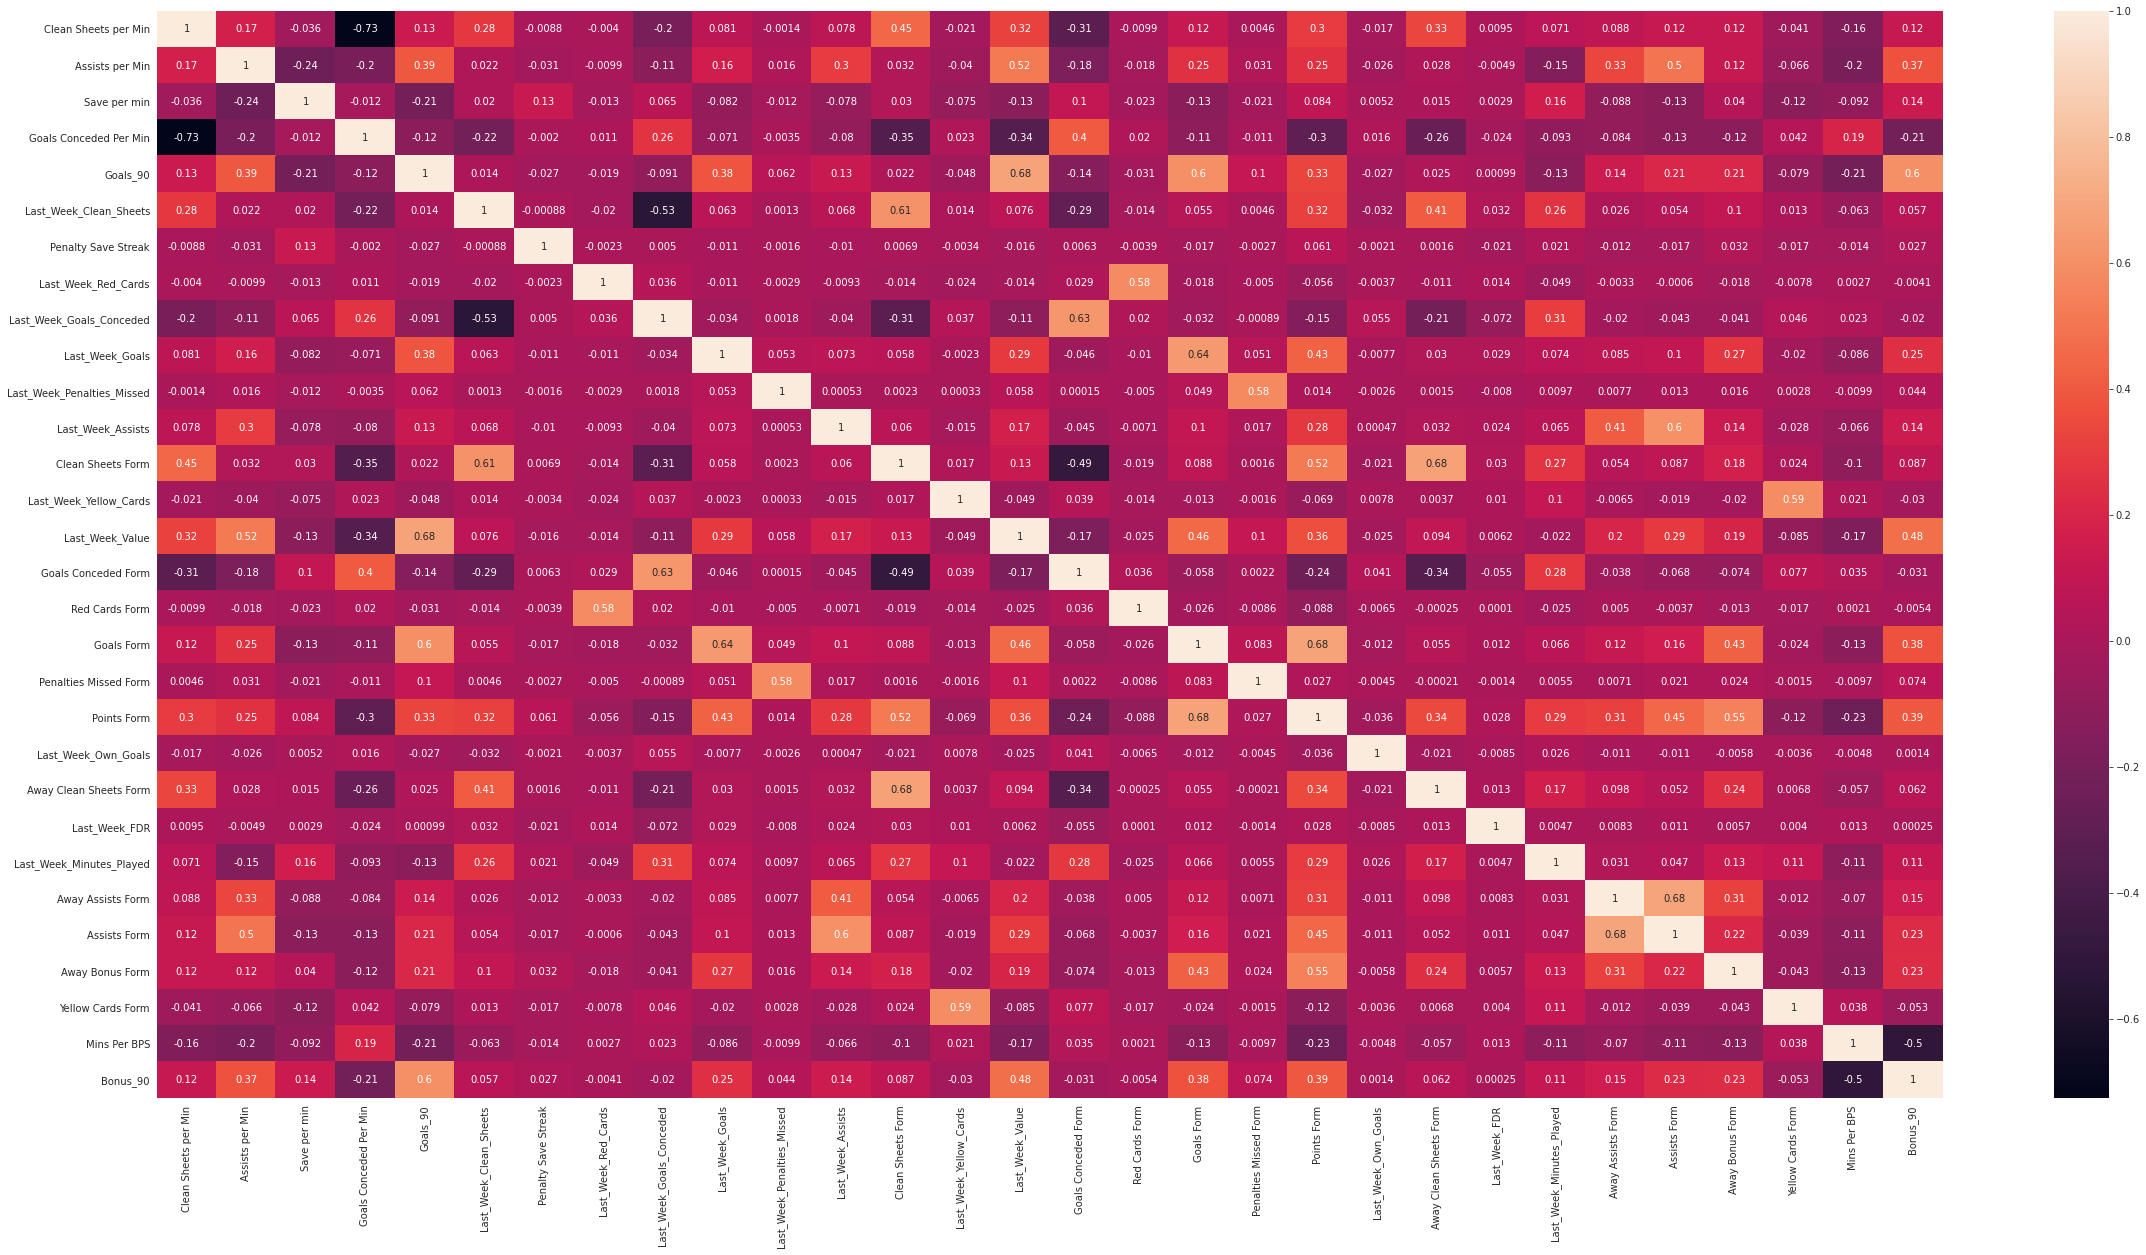

In [185]:
X1=gws2[['Clean Sheets per Min', 'Assists per Min', 'Save per min','Goals Conceded Per Min', 'Goals_90', 'Last_Week_Clean_Sheets', 'Penalty Save Streak', 'Last_Week_Red_Cards','Last_Week_Goals_Conceded','Last_Week_Goals','Last_Week_Penalties_Missed','Last_Week_Assists','Clean Sheets Form','Last_Week_Yellow_Cards','Last_Week_Value','Goals Conceded Form','Red Cards Form', 'Goals Form','Penalties Missed Form','Points Form','Last_Week_Own_Goals','Away Clean Sheets Form','Last_Week_FDR','Last_Week_Minutes_Played','Away Assists Form','Assists Form','Away Bonus Form','Yellow Cards Form','Mins Per BPS','Bonus_90']]
#X1=gws1[['Away ICT Form','Home ICT Form','Goals Conceded Form','Points Form','Bonus_90','Home Assists Form','Away Assists Form','Clean Sheets per Min','Assists per Min','Goals Conceded Per Min','Save per min','Last_Week_Penalties_Missed','Goals_90','Penalty Save Streak','Last_Week_Red_Cards','Penalties Missed Form','Last_Week_Own_Goals', 'Last_Week_Value','Clean Sheet Streak','Goal Streak','Goals Form','Red Cards Form']]
y1=y.astype(int)
plt.figure(figsize=(40,20))
sns.heatmap(X1.corr(),annot=True)
# smote=SMOTE(sampling_strategy='all')
print(sum(y1==0))
print(sum(y1==1))
# print(sum(y_train==3))
# print(sum(y_train==4))
# print(X_train.shape)
# X_train,y_train=smote.fit_sample(X_train,y_train)
# print(sum(y_train==1))
# print(sum(y_train==2))
# print(sum(y_train==3))
# print(sum(y_train==4))
# print(X_train.shape)


In [186]:
X_train, X_test, y_train, y_test = train_test_split( X1, y1, test_size=0.20, random_state=150)
smote=SMOTE(sampling_strategy='all')
X_train,y_train=smote.fit_sample(X_train,y_train)
print(sum(y_train==0))
print(sum(y_train==1))

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.



11719
11719


**Scaling the values**

In [187]:
# since we had a lot of attributes we decided the reduce it using PCA and scaled it
scaler= MinMaxScaler(feature_range=(0, 1), copy=True)
X_train=scaler.fit_transform(X_train)
X_test=scaler.transform(X_test)
# from sklearn.decomposition import PCA
# pca = PCA(0.90)
# pca.fit_transform(X_train)
# X_train=pca.transform(X_train)
# X_test=pca.transform(X_test)



In [ ]:
from sklearn.model_selection import StratifiedKFold

m = RandomForestClassifier(n_estimators=100, n_jobs=-1, max_features='sqrt', random_state=42)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(m, X_train, y_train, cv=cv, scoring='brier_score_loss')
print('Brier loss:', "{0:.5f}".format(np.mean(scores)*-1))

Brier loss: 0.02649


In [ ]:
# Create the parameter grid
params = {
    'min_samples_leaf': [3, 4, 5, 6, 7],
    'max_depth': [7, 8, 9, 10, 11]
}
 
# Create the grid search model
gs = GridSearchCV(estimator=m, param_grid=params, cv=cv, n_jobs=-1,
                  scoring='accuracy', return_train_score=True)
 
# Fit gs
gs.fit(X_train, y_train)
 
# Define function to print the results of the grid search
def print_gs_results(gs, print_all=True):
    if print_all == True:
        print('Grid scores:')
        means = gs.cv_results_['mean_test_score']*-1
        stds = gs.cv_results_['std_test_score']
        for mean, std, params in zip(means, stds, gs.cv_results_['params']):
            print("%0.5f (+/-%0.05f) for %r"
                  % (mean, std * 2, params))
        print()
        print('Best:', "{0:.5f}".format(gs.best_score_*-1),'using %s' % gs.best_params_)
    else:
        print('Best:', "{0:.5f}".format(gs.best_score_*-1),'using %s' % gs.best_params_)
    return
 
print_gs_results(gs=gs)

Grid scores:
-0.86368 (+/-0.00425) for {'max_depth': 7, 'min_samples_leaf': 3}
-0.86363 (+/-0.00983) for {'max_depth': 7, 'min_samples_leaf': 4}
-0.86359 (+/-0.00732) for {'max_depth': 7, 'min_samples_leaf': 5}
-0.86195 (+/-0.00532) for {'max_depth': 7, 'min_samples_leaf': 6}
-0.86162 (+/-0.00640) for {'max_depth': 7, 'min_samples_leaf': 7}
-0.87919 (+/-0.00578) for {'max_depth': 8, 'min_samples_leaf': 3}
-0.87851 (+/-0.00540) for {'max_depth': 8, 'min_samples_leaf': 4}
-0.87869 (+/-0.00620) for {'max_depth': 8, 'min_samples_leaf': 5}
-0.87770 (+/-0.00930) for {'max_depth': 8, 'min_samples_leaf': 6}
-0.87812 (+/-0.00554) for {'max_depth': 8, 'min_samples_leaf': 7}
-0.89249 (+/-0.00312) for {'max_depth': 9, 'min_samples_leaf': 3}
-0.89354 (+/-0.00678) for {'max_depth': 9, 'min_samples_leaf': 4}
-0.89129 (+/-0.00601) for {'max_depth': 9, 'min_samples_leaf': 5}
-0.89205 (+/-0.00490) for {'max_depth': 9, 'min_samples_leaf': 6}
-0.89039 (+/-0.00759) for {'max_depth': 9, 'min_samples_leaf': 

**Hyper parameter tuning of logistic regression**

In [ ]:
# #hyper parameter tuning
# model=LogisticRegression()
# solvers = ['newton-cg', 'lbfgs']
# penalty = ['l2']
# c_values = [100, 10, 1.0, 0.1, 0.01]
# # define grid search
# grid = dict(solver=solvers,penalty=penalty,C=c_values)
# cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
# grid_result = grid_search.fit(X_train, y_train)
# # summarize results
# print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
# means = grid_result.cv_results_['mean_test_score']
# stds = grid_result.cv_results_['std_test_score']
# params = grid_result.cv_results_['params']
# for mean, stdev, param in zip(means, stds, params):
#     print("%f (%f) with: %r" % (mean, stdev, param))

**Hyper Parameter tuning of KNN**

In [ ]:
# List Hyperparameters that we want to tune.
# leaf_size = list(range(1,50))
# n_neighbors = list(range(1,30))
# p=[1,2]
# #Convert to dictionary
# hyperparameters = dict(leaf_size=leaf_size, n_neighbors=n_neighbors, p=p)
# #Create new KNN object
# knn_2 = KNeighborsClassifier()
# #Use GridSearch
# clf = GridSearchCV(knn_2, hyperparameters, cv=10)
# #Fit the model
# best_model = clf.fit(X,y)
# #Print The value of best Hyperparameters
# print('Best leaf_size:', best_model.best_estimator_.get_params()['leaf_size'])
# print('Best p:', best_model.best_estimator_.get_params()['p'])
# print('Best n_neighbors:', best_model.best_estimator_.get_params()['n_neighbors'])

**Hyper parameter tuning of Extra Gradient Boosting**

In [188]:
from imblearn.combine import SMOTEENN
from sklearn.svm import SVC
from sklearn.utils import class_weight
# Observe how I imported Pipeline from IMBLEARN and not SKLEARN
from imblearn.pipeline import Pipeline
from sklearn.multiclass import OneVsRestClassifier
from imblearn.pipeline import Pipeline, make_pipeline

# kf = KFold(n_splits=5, random_state=42, shuffle=False)

# params = {
#     'n_estimators': [300],
#     'max_depth': [15,16,17],
#     'random_state': [20]
# }
# imba_pipeline = make_pipeline(SMOTE(random_state=42,sampling_strategy='all'), RandomForestClassifier( n_estimators=100,random_state=13,class_weight='balanced'))
# cross_val_score(imba_pipeline, X_train, y_train, scoring='accuracy', cv=kf)

# new_params = {'randomforestclassifier__' + key: params[key] for key in params}
# ovr = GridSearchCV(imba_pipeline, param_grid=new_params, cv=kf, scoring='accuracy',
#                         return_train_score=True)
ovr=RandomForestClassifier(max_depth= 11, min_samples_leaf= 3,n_estimators=300, class_weight='balanced',max_features='sqrt',bootstrap=True)
ovr.fit(X_train, y_train)

# This pipeline will resample the data and  
# pass the output to MultinomialNB
# pipe = Pipeline([('sampl', SMOTEENN()), 
#                  ('clf', LogisticRegression(max_iter=5000,class_weight='balanced'))])

# OVR will transform the `y` as you know and 
# then pass single label data to different copies of pipe 
# multiple times (as many labels in data)
# ovr = RandomForestClassifier()
# # ovr=SVC(decision_function_shape='ovr')
# cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
# # evaluate model
# scores = cross_val_score(ovr, X_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1)
# print(scores)
# # summarize performance
# print('Accuracy: %.3f' % np.mean(scores))
# ovr.fit(X_train, y_train)




RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=11, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=300,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [ ]:
# print(ovr.best_params_)
# print(ovr.best_score_)


In [ ]:
# #training the model


# #model=RandomForestClassifier()
# #model=RandomForestRegressor()
# #model=KNeighborsClassifier(leaf_size=1,p=2,n_neighbors=8)
# #model=LogisticRegression(C=10,solver='newton-cg',penalty='l2',class_weight='balanced')
# # model=XGBClassifier(scale_pos_weight=40,base_score=0.5, booster='gbtree', colsample_bylevel=1,
# #               colsample_bynode=1, colsample_bytree=1, gamma=0,
# #               learning_rate=0.1, max_delta_step=0, max_depth=6,
# #               min_child_weight=1, missing=None, n_estimators=180, n_jobs=1,
# #               nthread=4, objective='binary:logistic', random_state=0,
# #               reg_alpha=0, reg_lambda=1, seed=42,
# #               silent=None, subsample=1, verbosity=1)
# #model=DecisionTreeClassifier()
# #model=Lasso()
# #model=Ridge()
# #model=LinearRegression()
# #model=sm.OLS(X_train,y_train)
# #model=SGDRegressor(eta0=0.0001)
# model=LogisticRegression(max_iter=5000,class_weight='balanced')
# #model1 = BalancedRandomForestClassifier()
# #model1 = RandomForestClassifier(class_weight='balanced')
# model1= OneVsRestClassifier(model)


# # cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
# # # evaluate model
# # scores = cross_val_score(model1, X_train1, y_train1, scoring='accuracy', cv=cv, n_jobs=-1)
# # # summarize performance
# # print('Mean ROC AUC: %.3f' % np.mean(scores))

# model1.fit(X_train1, y_train)

**Predicting output for testing set**

In [189]:
from sklearn.metrics import roc_curve
#predicting the values 
# predict=model1.predict(X_test)
predict=ovr.predict(X_test)
predictp=ovr.predict_proba(X_test)


**Storing the output as well as the probabilities for each prediction in a dataframe**

In [190]:
# predict = model.predict(X_test)
df1=pd.DataFrame({'Actual':y_test,'Predicted':predict})
a=df1[1]=predictp[:,0].round(decimals=2)
b=df1[2]=predictp[:,1].round(decimals=2)
# df1[3]=predictp[:,2].round(decimals=2)
# df1[4]=predictp[:,3].round(decimals=2)

df1.head(40)


,Actual,Predicted,1,2
25837,0,0,0.88,0.12
3784,0,0,0.86,0.14
10401,0,0,0.88,0.12
11888,0,1,0.40,0.60
35086,0,0,0.87,0.13
11167,0,0,0.99,0.01
6252,0,0,0.85,0.15
29633,0,0,0.96,0.04
16572,0,1,0.41,0.59
14031,0,0,0.98,0.02


**Performance Metrics of the Model**

In [192]:
from sklearn.metrics import classification_report, confusion_matrix,auc, roc_auc_score
from sklearn.metrics import precision_score

print(classification_report(y_test,predict))
print(balanced_accuracy_score(y_test,predict))
print(confusion_matrix(y_test,predict))
print( roc_auc_score(y_test,a) )
print( roc_auc_score(y_test,b) )



              precision    recall  f1-score   support

           0       0.92      0.92      0.92      2930
           1       0.19      0.19      0.19       295

    accuracy                           0.85      3225
   macro avg       0.55      0.55      0.55      3225
weighted avg       0.85      0.85      0.85      3225

0.5536183259096431
[[2688  242]
 [ 239   56]]
0.2848134436281599
0.7151865563718401


In [ ]:
ovr.score(X_test,y_test)



0.8638700049742994


**Validation on unseen data( Not yet Ready)**

In [44]:
x=pd.read_csv('/content/drive/My Drive/combined_2016-2020-1.csv',encoding = "ISO-8859-1")

x.tail(200)


,name,assists,bonus,bps,clean_sheets,creativity,element,fixture,goals_conceded,goals_scored,ict_index,influence,kickoff_time,minutes,opponent_team,own_goals,penalties_missed,penalties_saved,red_cards,round,saves,selected,team_a_score,team_h_score,threat,total_points,transfers_balance,transfers_in,transfers_out,value,was_home,yellow_cards,gw
88958,Steve Cook,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-07-15T17:00:00Z,NaN,11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN,150
88959,Fabio Henrique Tavares,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-07-15T19:15:00Z,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN,150
88960,Anthony Driscoll-Glennon,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-07-15T17:00:00Z,NaN,20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,NaN,150
88961,David Martin,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-07-17T19:00:00Z,NaN,18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,NaN,150
88962,Danny Ings,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-07-16T19:15:00Z,NaN,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,NaN,150
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89153,Tyreke Johnson,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-07-16T19:15:00Z,NaN,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,NaN,150
89154,Robert Snodgrass,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-07-17T19:00:00Z,NaN,18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,NaN,150
89155,Scott Dann,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-07-16T19:15:00Z,NaN,12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,NaN,150
89156,Will Norris,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-07-15T17:00:00Z,NaN,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN,150


In [45]:
x=x.astype({'was_home':str})

In [46]:
x = x.assign(id=(x['name']).astype('category').cat.codes)


In [47]:
x.rename(columns={'opponent_team':'fdr'},inplace=True)


In [48]:
x['fdr']=x['fdr'].apply(fd).astype(float)


In [49]:
x['kickoff_time']=pd.to_datetime(x['kickoff_time'])

In [50]:
x['kickoff_time'] = x.kickoff_time.dt.hour

In [51]:
x['kickoff_time']=x['kickoff_time'].apply(time).astype(float)
x.tail(20)

,name,assists,bonus,bps,clean_sheets,creativity,element,fixture,goals_conceded,goals_scored,ict_index,influence,kickoff_time,minutes,fdr,own_goals,penalties_missed,penalties_saved,red_cards,round,saves,selected,team_a_score,team_h_score,threat,total_points,transfers_balance,transfers_in,transfers_out,value,was_home,yellow_cards,gw,id
89138,Neco Williams,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN,150,1063
89139,Abd-Al-Ali Morakinyo Olaposi Koiki,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,NaN,150,8
89140,John Ruddy,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN,150,704
89141,Oriol Romeu Vidal,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,NaN,150,1099
89142,Aaron Wan-Bissaka,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN,150,7
89143,JoseÌ Ignacio Peleteiro Romallo,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN,150,749
89144,Ryan Fraser,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN,150,1214
89145,Robert Elliot,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,NaN,150,1183
89146,Craig Cathcart,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN,150,291
89147,Kevin Danso,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,NaN,150,814


In [52]:
x['home']=x['was_home'].apply(was_home)
x.head()

,name,assists,bonus,bps,clean_sheets,creativity,element,fixture,goals_conceded,goals_scored,ict_index,influence,kickoff_time,minutes,fdr,own_goals,penalties_missed,penalties_saved,red_cards,round,saves,selected,team_a_score,team_h_score,threat,total_points,transfers_balance,transfers_in,transfers_out,value,was_home,yellow_cards,gw,id,home
0,Aaron Cresswell,0.0,0.0,0.0,0.0,0.0,454.0,10.0,0.0,0.0,0.0,0.0,2.0,0.0,3.0,0.0,0.0,0.0,0.0,1.0,0.0,14023.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,55.0,False,0.0,1,1,Away
1,Aaron Lennon,0.0,0.0,6.0,0.0,0.3,142.0,3.0,0.0,0.0,0.9,8.2,1.0,15.0,2.0,0.0,0.0,0.0,0.0,1.0,0.0,13918.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,60.0,True,0.0,1,2,Home
2,Aaron Ramsey,0.0,0.0,5.0,0.0,4.9,16.0,8.0,3.0,0.0,3.0,2.2,1.0,60.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,163170.0,4.0,3.0,23.0,2.0,0.0,0.0,0.0,80.0,True,0.0,1,5,Home
3,Abdoulaye Doucouré,0.0,0.0,0.0,0.0,0.0,482.0,7.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1051.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,50.0,False,0.0,1,12,Away
4,Abdul Rahman Baba,0.0,0.0,0.0,0.0,0.0,80.0,10.0,0.0,0.0,0.0,0.0,2.0,0.0,2.0,0.0,0.0,0.0,0.0,1.0,0.0,1243.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,55.0,True,0.0,1,13,Home


In [53]:
x['Away Points'] = np.where(x['home'] == 'Home', x['total_points'] * 0,x['total_points'])
x['Home Points'] = np.where(x['home'] == 'Away', x['total_points'] * 0,x['total_points'])

x['Away Influence'] = np.where(x['home'] == 'Home', x['influence'] * 0,x['influence'])
x['Home Influence'] = np.where(x['home'] == 'Away', x['influence'] * 0,x['influence'])

x['Away Goals'] = np.where(x['home'] == 'Home', x['goals_scored'] * 0,x['goals_scored'])
x['Home Goals'] = np.where(x['home'] == 'Away', x['goals_scored'] * 0,x['goals_scored'])

x['Away Saves'] = np.where(x['home'] == 'Home', x['saves'] * 0,x['saves'])
x['Home Saves'] = np.where(x['home'] == 'Away', x['saves'] * 0,x['saves'])

x['Away Creativity'] = np.where(x['home'] == 'Home', x['creativity'] * 0,x['creativity'])
x['Home Creativity'] = np.where(x['home'] == 'Away', x['creativity'] * 0,x['creativity'])

x['Away ICT'] = np.where(x['home'] == 'Home', x['ict_index'] * 0,x['ict_index'])
x['Home ICT'] = np.where(x['home'] == 'Away', x['ict_index'] * 0,x['ict_index'])

x['Away Bonus'] = np.where(x['home'] == 'Home', x['bonus'] * 0,x['bonus'])
x['Home Bonus'] = np.where(x['home'] == 'Away', x['bonus'] * 0,x['bonus'])

x['Away Clean Sheets'] = np.where(x['home'] == 'Home', x['clean_sheets'] * 0,x['clean_sheets'])
x['Home Clean Sheets'] = np.where(x['home'] == 'Away', x['clean_sheets'] * 0,x['clean_sheets'])

x['Away Penalties Saved'] = np.where(x['home'] == 'Home', x['penalties_saved'] * 0,x['penalties_saved'])
x['Home Penalties Saved'] = np.where(x['home'] == 'Away', x['penalties_saved'] * 0,x['penalties_saved'])

x['Away Goals Conceded'] = np.where(x['home'] == 'Home', x['goals_conceded'] * 0,x['goals_conceded'])
x['Home Goals Conceded'] = np.where(x['home'] == 'Away', x['goals_conceded'] * 0,x['goals_conceded'])

x['Away Assists'] = np.where(x['home'] == 'Home', x['assists'] * 0,x['assists'])
x['Home Assists'] = np.where(x['home'] == 'Away', x['assists'] * 0,x['assists'])

x.tail(100)


,name,assists,bonus,bps,clean_sheets,creativity,element,fixture,goals_conceded,goals_scored,ict_index,influence,kickoff_time,minutes,fdr,own_goals,penalties_missed,penalties_saved,red_cards,round,saves,selected,team_a_score,team_h_score,threat,total_points,transfers_balance,transfers_in,transfers_out,value,was_home,yellow_cards,gw,id,home,Away Points,Home Points,Away Influence,Home Influence,Away Goals,Home Goals,Away Saves,Home Saves,Away Creativity,Home Creativity,Away ICT,Home ICT,Away Bonus,Home Bonus,Away Clean Sheets,Home Clean Sheets,Away Penalties Saved,Home Penalties Saved,Away Goals Conceded,Home Goals Conceded,Away Assists,Home Assists
89058,Danny Ward,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,NaN,150,331,Home,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
89059,Ryan Giles,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN,150,1216,Away,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
89060,Moussa Djenepo,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,NaN,150,1035,Home,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
89061,Alex Iwobi,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,NaN,150,60,Home,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
89062,Mason Greenwood,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN,150,951,Away,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89153,Tyreke Johnson,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,NaN,150,1357,Home,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
89154,Robert Snodgrass,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,NaN,150,1187,Home,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
89155,Scott Dann,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,NaN,150,1248,Home,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
89156,Will Norris,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN,150,1395,Away,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [54]:
x.drop(['element','fixture','round','transfers_balance','transfers_in','transfers_out','team_a_score','was_home',	'team_h_score','round'],axis=1, inplace=True)

In [55]:
x['value']=x['value']*0.1


In [56]:
x['points']=x['total_points'].apply(points)
x.tail(100)

,name,assists,bonus,bps,clean_sheets,creativity,goals_conceded,goals_scored,ict_index,influence,kickoff_time,minutes,fdr,own_goals,penalties_missed,penalties_saved,red_cards,saves,selected,threat,total_points,value,yellow_cards,gw,id,home,Away Points,Home Points,Away Influence,Home Influence,Away Goals,Home Goals,Away Saves,Home Saves,Away Creativity,Home Creativity,Away ICT,Home ICT,Away Bonus,Home Bonus,Away Clean Sheets,Home Clean Sheets,Away Penalties Saved,Home Penalties Saved,Away Goals Conceded,Home Goals Conceded,Away Assists,Home Assists,points
89058,Danny Ward,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,150,331,Home,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
89059,Ryan Giles,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,150,1216,Away,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
89060,Moussa Djenepo,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,150,1035,Home,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
89061,Alex Iwobi,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,150,60,Home,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
89062,Mason Greenwood,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,150,951,Away,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89153,Tyreke Johnson,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,150,1357,Home,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
89154,Robert Snodgrass,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,150,1187,Home,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
89155,Scott Dann,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,150,1248,Home,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
89156,Will Norris,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,150,1395,Away,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1


In [57]:
home=pd.get_dummies(x['home'])
x=pd.concat([x,home],axis=1)
x.head(100)

,name,assists,bonus,bps,clean_sheets,creativity,goals_conceded,goals_scored,ict_index,influence,kickoff_time,minutes,fdr,own_goals,penalties_missed,penalties_saved,red_cards,saves,selected,threat,total_points,value,yellow_cards,gw,id,home,Away Points,Home Points,Away Influence,Home Influence,Away Goals,Home Goals,Away Saves,Home Saves,Away Creativity,Home Creativity,Away ICT,Home ICT,Away Bonus,Home Bonus,Away Clean Sheets,Home Clean Sheets,Away Penalties Saved,Home Penalties Saved,Away Goals Conceded,Home Goals Conceded,Away Assists,Home Assists,points,Away,Home
0,Aaron Cresswell,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,14023.0,0.0,0.0,5.5,0.0,1,1,Away,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0
1,Aaron Lennon,0.0,0.0,6.0,0.0,0.3,0.0,0.0,0.9,8.2,1.0,15.0,2.0,0.0,0.0,0.0,0.0,0.0,13918.0,0.0,1.0,6.0,0.0,1,2,Home,0.0,1.0,0.0,8.2,0.0,0.0,0.0,0.0,0.0,0.3,0.0,0.9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,1
2,Aaron Ramsey,0.0,0.0,5.0,0.0,4.9,3.0,0.0,3.0,2.2,1.0,60.0,1.0,0.0,0.0,0.0,0.0,0.0,163170.0,23.0,2.0,8.0,0.0,1,5,Home,0.0,2.0,0.0,2.2,0.0,0.0,0.0,0.0,0.0,4.9,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0,0,1
3,Abdoulaye Doucouré,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1051.0,0.0,0.0,5.0,0.0,1,12,Away,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0
4,Abdul Rahman Baba,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,1243.0,0.0,0.0,5.5,0.0,1,13,Home,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,Christian Fuchs,0.0,0.0,17.0,0.0,13.8,2.0,0.0,5.6,25.4,0.0,90.0,1.0,0.0,0.0,0.0,0.0,0.0,418306.0,17.0,0.0,5.5,1.0,1,267,Away,0.0,0.0,25.4,0.0,0.0,0.0,0.0,0.0,13.8,0.0,5.6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0,1,0
96,Christian Kabasele,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2810.0,0.0,0.0,5.0,0.0,1,268,Away,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0
97,Chris Brunt,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,819.0,0.0,0.0,5.0,0.0,1,258,Away,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0
98,Chris Long,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,35760.0,0.0,0.0,4.5,0.0,1,259,Home,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,1


In [58]:
x['Last_Week_Points'] = x.groupby(['id'])['points'].shift().astype(float)
# x['Last_2_Week_Points'] = x.groupby(['id'])['points'].shift(2).astype(float)
#x['Last_3_Week_Points'] = x.groupby(['id'])['total_points'].shift(3).astype(float)
#x['Last_4_Week_Points'] = x.groupby(['id'])['total_points'].shift(4).astype(float)



x['Last_Week_Goals'] = x.groupby(['id'])['goals_scored'].shift().astype(float)
# x['Last_2_Week_Goals'] = x.groupby(['id'])['goals_scored'].shift(2).astype(float)
#x['Last_3_Week_Goals'] = x.groupby(['id'])['goals_scored'].shift(3).astype(float)


x['Last_Week_ICT'] = x.groupby(['id'])['ict_index'].shift().astype(float)
x['Last_2_Week_ICT'] = x.groupby(['id'])['ict_index'].shift(2).astype(float)
# #x['Last_3_Week_ICT'] = x.groupby(['id'])['ict_index'].shift(3).astype(float)


x['Last_Week_BPS'] = x.groupby(['id'])['bps'].shift().astype(float)
x['Last_2_Week_BPS'] = x.groupby(['id'])['bps'].shift(2).astype(float)
#x['Last_3_Week_BPS'] = x.groupby(['id'])['bps'].shift(3).astype(float)


x['Last_Week_Assists'] = x.groupby(['id'])['assists'].shift().astype(float)
x['Last_2_Week_Assists'] = x.groupby(['id'])['assists'].shift(2).astype(float)
#x['Last_3_Week_Assists'] = x.groupby(['id'])['assists'].shift(3).astype(float)


x['Last_Week_Bonus'] = x.groupby(['id'])['bonus'].shift().astype(float)
x['Last_2_Week_Bonus'] = x.groupby(['id'])['bonus'].shift(2).astype(float)
#x['Last_3_Week_Bonus'] = x.groupby(['id'])['bonus'].shift(3).astype(float)


x['Last_Week_Penalties_Saved'] = x.groupby(['id'])['penalties_saved'].shift().astype(float)
x['Last_2_Week_Penalties_Saved'] =x.groupby(['id'])['penalties_saved'].shift(2).astype(float)


x['Last_Week_Influence'] = x.groupby(['id'])['influence'].shift().astype(float)
x['Last_2_Week_Influence'] = x.groupby(['id'])['influence'].shift(2).astype(float)
#x['Last_3_Week_Influence'] = x.groupby(['id'])['influence'].shift(3).astype(float)


x['Last_Week_Minutes_Played'] = x.groupby(['id'])['minutes'].shift().astype(float)
x['Last_2_Week_Minutes_Played'] = x.groupby(['id'])['minutes'].shift(2).astype(float)
#x['Last_3_Week_Minutes_Played'] = x.groupby(['id'])['minutes'].shift(3).astype(float)


x['Last_Week_Threat'] = x.groupby(['id'])['threat'].shift().astype(float)
x['Last_2_Week_Threat'] = x.groupby(['id'])['threat'].shift(2).astype(float)
# #x['Last_3_Week_Threat'] = x.groupby(['id'])['threat'].shift(3).astype(float)


x['Last_Week_Selected'] = x.groupby(['id'])['selected'].shift().astype(float)
x['Last_2_Week_Selected'] = x.groupby(['id'])['selected'].shift(2).astype(float)
#x['Last_3_Week_Selected'] = x.groupby(['id'])['selected'].shift(3).astype(float)


x['Last_Week_Value'] = x.groupby(['id'])['value'].shift().astype(float)
x['Last_2_Week_Value'] = x.groupby(['id'])['value'].shift(2).astype(float)
# x['Last_3_Week_Value'] = x.groupby(['id'])['value'].shift(3).astype(float)


x['Last_Week_Creativity'] = x.groupby(['id'])['creativity'].shift().astype(float)
x['Last_2_Week_Creativity'] = x.groupby(['id'])['creativity'].shift(2).astype(float)
# #x['Last_3_Week_Creativity'] = x.groupby(['id'])['creativity'].shift(3).astype(float)



x['Last_Week_FDR'] = x.groupby(['id'])['fdr'].shift().astype(float).astype(float)
x['Last_2_Week_FDR'] = x.groupby(['id'])['fdr'].shift(2).astype(float).astype(float)
x['Last_3_Week_FDR'] = x.groupby(['id'])['fdr'].shift(3).astype(float).astype(float)


x['Last_Week_Clean_Sheets'] = x.groupby(['id'])['clean_sheets'].shift().astype(float)
x['Last_2_Week_Clean_Sheets'] = x.groupby(['id'])['clean_sheets'].shift(2).astype(float)
#x['Last_3_Week_Clean_Sheets'] = x.groupby(['id'])['clean_sheets'].shift(3).astype(float)


x['Last_Week_Goals_Conceded'] = x.groupby(['id'])['goals_conceded'].shift().astype(float)
x['Last_2_Week_Goals_Conceded'] = x.groupby(['id'])['goals_conceded'].shift(2).astype(float)
#x['Last_3_Week_Goals_Conceded'] = x.groupby(['id'])['goals_conceded'].shift(3).astype(float)


# x['Last_Week_Kickoff_Time'] = x.groupby(['id'])['kickoff_time'].shift().astype(float)
# x['Last_2_Week_Kickoff_Time'] = x.groupby(['id'])['kickoff_time'].shift(2).astype(float)
# x['Last_3_Week_Kickoff_Time'] = x.groupby(['id'])['kickoff_time'].shift(3).astype(float)


x['Last_Week_Own_Goals'] = x.groupby(['id'])['own_goals'].shift().astype(float)
x['Last_2_Week_Own_Goals'] = x.groupby(['id'])['own_goals'].shift(2).astype(float)
# x['Last_3_Week_Own_Goals'] = x.groupby(['id'])['own_goals'].shift(3).astype(float)

x['Last_Week_Penalties_Saved'] = x.groupby(['id'])['penalties_saved'].shift().astype(float)

x['Last_Week_Penalties_Missed'] = x.groupby(['id'])['penalties_missed'].shift().astype(float)
x['Last_2_Week_Penalties_Missed'] = x.groupby(['id'])['penalties_missed'].shift(2).astype(float)
# x['Last_3_Week_Penalties_Saved'] = x.groupby(['id'])['penalties_saved'].shift(3).astype(float)


x['Last_Week_Red_Cards'] = x.groupby(['id'])['red_cards'].shift().astype(float)
x['Last_2_Week_Red_Cards'] = x.groupby(['id'])['red_cards'].shift(2).astype(float)
# x['Last_3_Week_Red_Cards'] = x.groupby(['id'])['red_cards'].shift(3).astype(float)


x['Last_Week_Saves'] = x.groupby(['id'])['saves'].shift().astype(float)
x['Last_2_Week_Saves'] = x.groupby(['id'])['saves'].shift(2).astype(float)
#x['Last_3_Week_Saves'] = x.groupby(['id'])['saves'].shift(3)


x['Last_Week_Yellow_Cards'] = x.groupby(['id'])['yellow_cards'].shift().astype(float)
x['Last_2_Week_Yellow_Cards'] = x.groupby(['id'])['yellow_cards'].shift(2).astype(float)
# x['Last_3_Week_Yellow_Cards'] = x.groupby(['id'])['yellow_cards'].shift(3)


# x['Last_Week_Home'] = x.groupby(['id'])['home'].shift()
# x['Last_2_Week_Home'] = x.groupby(['id'])['home'].shift(2)
# x['Last_3_Week_Home'] = x.groupby(['id'])['home'].shift(3)
#feature engineered a number of variables to better define the dependent variable
window=3

hpm =x.groupby('id',as_index=False)['Home Points'].rolling(window=window).sum().shift(1).astype(float)
x["Home Points Form"] = hpm.reset_index(level=0, drop=True)

apm =x.groupby('id',as_index=False)['Away Points'].rolling(window=window).sum().shift(1).astype(float)
x["Away Points Form"] = apm.reset_index(level=0, drop=True)

ppm =(x.groupby('id',as_index=False)['total_points'].expanding().sum()/x.groupby('id',as_index=False)['minutes'].expanding().sum()*90).astype(float)
x["Points_90"] = ppm.reset_index(level=0, drop=True)

vm =(x.groupby('id',as_index=False)['value'].expanding().sum()/x.groupby('id',as_index=False)['total_points'].expanding().sum()*90).astype(float)
x["Value_Point"] = vm.reset_index(level=0, drop=True)

apm =x.groupby('id',as_index=False)['assists'].expanding().sum()/x.groupby('id',as_index=False)['minutes'].expanding().sum().astype(float)
x["Assists per Min"] = apm.reset_index(level=0, drop=True)

gpm =(x.groupby('id',as_index=False)['goals_scored'].expanding().sum()/x.groupby('id',as_index=False)['minutes'].expanding().sum()*90).astype(float)
x["Goals_90"] = gpm.reset_index(level=0, drop=True)

ipm =(x.groupby('id',as_index=False)['influence'].expanding().sum()/x.groupby('id',as_index=False)['minutes'].expanding().sum()*90).astype(float)
x["Influence_90"] = ipm.reset_index(level=0, drop=True)

bpm =(x.groupby('id',as_index=False)['bonus'].expanding().sum()/x.groupby('id',as_index=False)['minutes'].expanding().sum()*90).astype(float)
x["Bonus_90"] = ipm.reset_index(level=0, drop=True)

ih =x.groupby(['id','name'],as_index=False)['Home Influence'].rolling(window=window).sum().shift(1).astype(float)
x["Home Influence Form"] = ih.reset_index(level=0, drop=True)

ah =x.groupby('id',as_index=False)['Away Influence'].rolling(window=window).sum().shift(1).astype(float)
x["Away Influence Form"] = ah.reset_index(level=0, drop=True)

hg =x.groupby('id',as_index=False)['Home Goals'].rolling(window=window).sum().shift(1).astype(float)
x["Home Goals Form"] = hg.reset_index(level=0, drop=True)

ag =x.groupby('id',as_index=False)['Away Goals'].rolling(window=window).sum().shift(1).astype(float)
x["Away Goals Form"] = hg.reset_index(level=0, drop=True)


gs =x.groupby('id',as_index=False)['goals_scored'].rolling(window=window).sum().shift(1).astype(float)
x["Goals Form"] = gs.reset_index(level=0, drop=True)

ag =x.groupby('id',as_index=False)['clean_sheets'].expanding().sum()/x.groupby('id',as_index=False)['minutes'].expanding().sum().astype(float)
x["Clean Sheets per Min"] = ag.reset_index(level=0, drop=True)

cs =x.groupby('id',as_index=False)['total_points'].expanding().sum()/x.groupby('id',as_index=False)['minutes'].expanding().sum().astype(float)
x["Points Per Min"] = cs.reset_index(level=0, drop=True)

gc =x.groupby('id',as_index=False)['goals_conceded'].expanding().sum()/x.groupby('id',as_index=False)['minutes'].expanding().sum().astype(float)
x["Goals Conceded Per Min"] = gc.reset_index(level=0, drop=True)

s =x.groupby('id',as_index=False)['saves'].expanding().sum()/x.groupby('id',as_index=False)['minutes'].expanding().sum().astype(float)
x["Save per min"] = s.reset_index(level=0, drop=True)

sh =x.groupby('id',as_index=False)['Home Saves'].rolling(window=window).sum().shift(1).astype(float)
x["Home Saves Form"] = sh.reset_index(level=0, drop=True)

sa =x.groupby('id',as_index=False)['Away Saves'].rolling(window=window).sum().shift(1).astype(float)
x["Away Saves Form"] = sa.reset_index(level=0, drop=True)

sf =x.groupby('id',as_index=False)['saves'].rolling(window=window).sum().shift(1).astype(float)
x["Saves Form"] = sf.reset_index(level=0, drop=True)

mp =x.groupby('id',as_index=False)['minutes'].rolling(window=window).sum().shift(1).astype(float)
x["Minutes Form"] = mp.reset_index(level=0, drop=True)

ch =x.groupby('id',as_index=False)['Home Creativity'].rolling(window=window).sum().shift(1).astype(float)
x["Home Creativity Form"] = ch.reset_index(level=0, drop=True)

ca =x.groupby('id',as_index=False)['Away Creativity'].rolling(window=window).sum().shift(1).astype(float)
x["Away Creativity Form"] = ca.reset_index(level=0, drop=True)

csh =x.groupby('id',as_index=False)['Home Clean Sheets'].rolling(window=window).sum().shift(1).astype(float)
x[" Home Clean Sheets Form"] = csh.reset_index(level=0, drop=True)

csa =x.groupby('id',as_index=False)['Away Clean Sheets'].rolling(window=window).sum().shift(1).astype(float)
x["Away Clean Sheets Form"] = csa.reset_index(level=0, drop=True)

cs =x.groupby('id',as_index=False)['clean_sheets'].rolling(window=window).sum().shift(1).astype(float)
x["Clean Sheets Form"] = cs.reset_index(level=0, drop=True)

bph =x.groupby('id',as_index=False)['Home Bonus'].rolling(window=window).sum().shift(1).astype(float)
x['Home Bonus Form'] = bph.reset_index(level=0, drop=True)

bp =x.groupby('id',as_index=False)['bonus'].rolling(window=window).sum().shift(1).astype(float)
x['Bonus Form'] = bp.reset_index(level=0, drop=True)

bpa =x.groupby('id',as_index=False)['Away Bonus'].rolling(window=window).sum().shift(1).astype(float)
x["Away Bonus Form"] = bpa.reset_index(level=0, drop=True)

icth =x.groupby('id',as_index=False)['Home ICT'].rolling(window=window).sum().shift(1).astype(float)
x['Home ICT Form'] = icth.reset_index(level=0, drop=True)

icta =x.groupby('id',as_index=False)['Away ICT'].rolling(window=window).sum().shift(1).astype(float)
x["Away ICT Form"] = icta.reset_index(level=0, drop=True)


ict =x.groupby('id',as_index=False)['ict_index'].rolling(window=window).sum().shift(1).astype(float)
x["ICT Form"] = ict.reset_index(level=0, drop=True)

ah =x.groupby('id',as_index=False)['Home Assists'].rolling(window=window).sum().shift(1).astype(float)
x['Home Assists Form'] = ah.reset_index(level=0, drop=True)

aa =x.groupby('id',as_index=False)['Away Assists'].rolling(window=window).sum().shift(1).astype(float)
x["Away Assists Form"] = aa.reset_index(level=0, drop=True)

ast =x.groupby('id',as_index=False)['assists'].rolling(window=window).sum().shift(1).astype(float)
x["Assists Form"] = ast.reset_index(level=0, drop=True)

# ms =x.groupby('id',as_index=False)['minutes'+0.0000001].expanding().sum()/x.groupby('id',as_index=False)['saves'+0.0000001].expanding().sum()
# x["Mins Per Save"] = ms.reset_index(level=0, drop=True)

bpss =x.groupby('id',as_index=False)['minutes'].expanding().sum()/x.groupby('id',as_index=False)['bps'].expanding().sum().astype(float)
x["Mins Per BPS"] = bpss.reset_index(level=0, drop=True)

gca =x.groupby('id',as_index=False)['Away Goals Conceded'].rolling(window=5).sum().shift(1).astype(float)
x["Away Goals Concecded Form"] = gca.reset_index(level=0, drop=True)

gch =x.groupby('id',as_index=False)['Home Goals Conceded'].rolling(window=5).sum().shift(1).astype(float)
x["Goals Conceded Home"] = gch.reset_index(level=0, drop=True)

gc =x.groupby('id',as_index=False)['goals_conceded'].rolling(window=5).sum().shift(1).astype(float)
x["Goals Conceded Form"] = gc.reset_index(level=0, drop=True)

gcm =x.groupby('id',as_index=False)['minutes'].expanding().sum()/x.groupby('id',as_index=False)['goals_conceded'].expanding().sum().astype(float)
x["Mins per Goals Conceded"] = gcm.reset_index(level=0, drop=True)

tp =x.groupby('id',as_index=False)['total_points'].rolling(window=window).sum().shift(1).astype(float)
x["Points Form"] = tp.reset_index(level=0, drop=True)

pm =x.groupby('id',as_index=False)['penalties_missed'].rolling(window=window).sum().shift(1).astype(float)
x["Penalties Missed Form"] = pm.reset_index(level=0, drop=True)

yc =x.groupby('id',as_index=False)['yellow_cards'].rolling(window=window).sum().shift(1).astype(float)
x["Yellow Cards Form"] = yc.reset_index(level=0, drop=True)

rc =x.groupby('id',as_index=False)['red_cards'].rolling(window=window).sum().shift(1).astype(float)
x["Red Cards Form"] = rc.reset_index(level=0, drop=True)
# ms =x1.groupby('id',as_index=False)['minutes'+0.0000001].expanding().sum()/x1.groupby('id',as_index=False)['saves'+0.0000001].expanding().sum()
# x1["Mins Per Save"] = ms.reset_index(level=0, drop=True)

bpss =x.groupby('id',as_index=False)['minutes'].expanding().sum()/x.groupby('id',as_index=False)['bps'].expanding().sum().astype(float)
x["Mins Per BPS"] = bpss.reset_index(level=0, drop=True)

gca =x.groupby('id',as_index=False)['goals_conceded'].expanding().sum()/x.groupby('id',as_index=False)['Away'].expanding().sum().astype(float)
x["Goals Concecded Away"] = gca.reset_index(level=0, drop=True)

gch =x.groupby('id',as_index=False)['goals_conceded'].expanding().sum()/x.groupby('id',as_index=False)['Home'].expanding().sum().astype(float)
x["Goals Conceded Home"] = gch.reset_index(level=0, drop=True)

gcm =x.groupby('id',as_index=False)['minutes'].expanding().sum()/x.groupby('id',as_index=False)['goals_conceded'].expanding().sum().astype(float)
x["Mins per Goals Conceded"] = gcm.reset_index(level=0, drop=True)


x.head(100)

,name,assists,bonus,bps,clean_sheets,creativity,goals_conceded,goals_scored,ict_index,influence,kickoff_time,minutes,fdr,own_goals,penalties_missed,penalties_saved,red_cards,saves,selected,threat,total_points,value,yellow_cards,gw,id,home,Away Points,Home Points,Away Influence,Home Influence,Away Goals,Home Goals,Away Saves,Home Saves,Away Creativity,Home Creativity,Away ICT,Home ICT,Away Bonus,Home Bonus,...,Goals_90,Influence_90,Bonus_90,Home Influence Form,Away Influence Form,Home Goals Form,Away Goals Form,Goals Form,Clean Sheets per Min,Points Per Min,Goals Conceded Per Min,Save per min,Home Saves Form,Away Saves Form,Saves Form,Minutes Form,Home Creativity Form,Away Creativity Form,Home Clean Sheets Form,Away Clean Sheets Form,Clean Sheets Form,Home Bonus Form,Bonus Form,Away Bonus Form,Home ICT Form,Away ICT Form,ICT Form,Home Assists Form,Away Assists Form,Assists Form,Mins Per BPS,Away Goals Concecded Form,Goals Conceded Home,Goals Conceded Form,Mins per Goals Conceded,Points Form,Penalties Missed Form,Yellow Cards Form,Red Cards Form,Goals Concecded Away
0,Aaron Cresswell,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,14023.0,0.0,0.0,5.5,0.0,1,1,Away,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
1,Aaron Lennon,0.0,0.0,6.0,0.0,0.3,0.0,0.0,0.9,8.2,1.0,15.0,2.0,0.0,0.0,0.0,0.0,0.0,13918.0,0.0,1.0,6.0,0.0,1,2,Home,0.0,1.0,0.0,8.2,0.0,0.0,0.0,0.0,0.0,0.3,0.0,0.9,0.0,0.0,...,0.0,49.2,49.2,NaN,NaN,NaN,NaN,NaN,0.0,0.066667,0.000000,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.500000,NaN,0.0,NaN,inf,NaN,NaN,NaN,NaN,NaN
2,Aaron Ramsey,0.0,0.0,5.0,0.0,4.9,3.0,0.0,3.0,2.2,1.0,60.0,1.0,0.0,0.0,0.0,0.0,0.0,163170.0,23.0,2.0,8.0,0.0,1,5,Home,0.0,2.0,0.0,2.2,0.0,0.0,0.0,0.0,0.0,4.9,0.0,3.0,0.0,0.0,...,0.0,3.3,3.3,NaN,NaN,NaN,NaN,NaN,0.0,0.033333,0.050000,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.000000,NaN,3.0,NaN,20.0,NaN,NaN,NaN,NaN,inf
3,Abdoulaye Doucouré,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1051.0,0.0,0.0,5.0,0.0,1,12,Away,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,9.6,1.880000e+01,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,270.0,7.9,1.700000e+00,0.0,0.0,0.0,0.0,0.0,0.0,5.5,2.100000e+00,7.6,0.0,0.0,0.0,NaN,4.0,NaN,9.0,NaN,6.0,0.0,0.0,0.0,0.0
4,Abdul Rahman Baba,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,1243.0,0.0,0.0,5.5,0.0,1,13,Home,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,26.8,1.260000e+01,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,270.0,38.9,2.430000e+01,0.0,0.0,0.0,0.0,0.0,0.0,11.2,6.100000e+00,17.3,0.0,0.0,0.0,NaN,4.0,0.0,11.0,NaN,5.0,0.0,1.0,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,Christian Fuchs,0.0,0.0,17.0,0.0,13.8,2.0,0.0,5.6,25.4,0.0,90.0,1.0,0.0,0.0,0.0,0.0,0.0,418306.0,17.0,0.0,5.5,1.0,1,267,Away,0.0,0.0,25.4,0.0,0.0,0.0,0.0,0.0,13.8,0.0,5.6,0.0,0.0,0.0,...,0.0,25.4,25.4,NaN,NaN,NaN,NaN,NaN,0.0,0.000000,0.022222,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.294118,NaN,inf,NaN,45.0,NaN,NaN,NaN,NaN,2.0
96,Christian Kabasele,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2810.0,0.0,0.0,5.0,0.0,1,268,Away,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
97,Chris Brunt,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,8

In [59]:
dx=x.groupby('id').apply(f)
x=x.groupby('id').apply(f2)
x=x.groupby('id').apply(f3)

NameError: ignored

In [60]:
x.to_csv('/content/drive/My Drive/viz.csv')
x1=x[x['gw']==150]
x1.head(40)

,name,assists,bonus,bps,clean_sheets,creativity,goals_conceded,goals_scored,ict_index,influence,kickoff_time,minutes,fdr,own_goals,penalties_missed,penalties_saved,red_cards,saves,selected,threat,total_points,value,yellow_cards,gw,id,home,Away Points,Home Points,Away Influence,Home Influence,Away Goals,Home Goals,Away Saves,Home Saves,Away Creativity,Home Creativity,Away ICT,Home ICT,Away Bonus,Home Bonus,...,Goals_90,Influence_90,Bonus_90,Home Influence Form,Away Influence Form,Home Goals Form,Away Goals Form,Goals Form,Clean Sheets per Min,Points Per Min,Goals Conceded Per Min,Save per min,Home Saves Form,Away Saves Form,Saves Form,Minutes Form,Home Creativity Form,Away Creativity Form,Home Clean Sheets Form,Away Clean Sheets Form,Clean Sheets Form,Home Bonus Form,Bonus Form,Away Bonus Form,Home ICT Form,Away ICT Form,ICT Form,Home Assists Form,Away Assists Form,Assists Form,Mins Per BPS,Away Goals Concecded Form,Goals Conceded Home,Goals Conceded Form,Mins per Goals Conceded,Points Form,Penalties Missed Form,Yellow Cards Form,Red Cards Form,Goals Concecded Away
88504,Charlie Austin,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,150,248,Home,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.461066,22.604508,22.604508,1.865175e-14,-1.776357e-15,0.0,0.0,0.0,0.005123,0.061475,0.013661,0.000000,0.0,0.0,0.0,0.0,-7.438494e-15,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,9.159340e-16,-1.776357e-15,9.159340e-16,0.0,0.0,0.0,5.323636,0.0,0.533333,0.0,73.200000,0.0,0.0,0.0,0.0,0.533333
88505,Mark Noble,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,150,932,Home,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.151787,17.795088,17.795088,-3.552714e-15,4.860000e+01,0.0,0.0,0.0,0.003057,0.036787,0.016549,0.000000,0.0,0.0,0.0,109.0,7.105427e-15,1.166000e+02,0.0,1.0,1.0,0.0,1.0,1.0,-5.329071e-15,1.710000e+01,1.710000e+01,0.0,1.0,1.0,5.393405,2.0,2.093333,2.0,60.426752,8.0,0.0,0.0,0.0,2.093333
88506,Simon Mignolet,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,150,1278,Away,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000000,15.791489,15.791489,-8.881784e-15,-7.993606e-15,0.0,0.0,0.0,0.003783,0.041844,0.012766,0.020804,0.0,0.0,0.0,0.0,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,-8.881784e-16,-9.992007e-16,1.221245e-15,0.0,0.0,0.0,5.065868,0.0,0.720000,0.0,78.333333,0.0,0.0,0.0,0.0,0.720000
88507,Bruno Miguel Borges Fernandes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,150,218,Away,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.683297,48.201735,48.201735,1.050000e+02,5.960000e+01,1.0,1.0,2.0,0.007592,0.107375,0.005423,0.000000,0.0,0.0,0.0,243.0,1.003000e+02,4.490000e+01,0.0,1.0,1.0,2.0,5.0,3.0,2.390000e+01,1.300000e+01,3.690000e+01,3.0,1.0,4.0,2.917722,0.0,0.833333,3.0,184.400000,34.0,0.0,0.0,0.0,0.833333
88508,Djibril SidibeÌ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,150,389,Home,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
88509,Victor LindeloÌf,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,150,1367,Away,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,-2.664535e-15,3.000000e+00,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,10.0,0.000000e+00,1.150000e+01,0.0,0.0,0.0,0.0,0.0,0.0,1.165734e-15,1.700000e+00,1.700000e+00,0.0,0.0,0.0,NaN,0.0,NaN,1.0,NaN,1.0,0.0,0.0,0.0,NaN
88510,Laurent Koscielny,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,150,843,Home,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.098824,27.947294,27.947294,7.105427e-15,-1.065814e-14,0.0,0.0,0.0,0.003451,0.044392,0.014431,0.000

In [ ]:

x_test=x1[['Clean Sheets per Min', 'Assists per Min', 'Save per min','Goals Conceded Per Min', 'Goals_90', 'Last_Week_Clean_Sheets', 'Penalty Save Streak', 'Last_Week_Red_Cards','Last_Week_Goals_Conceded','Last_Week_Goals','Last_Week_Penalties_Missed','Last_Week_Assists','Clean Sheets Form','Last_Week_Yellow_Cards','Last_Week_Value','Goals Conceded Form','Red Cards Form', 'Goals Form','Penalties Missed Form','Points Form','Last_Week_Own_Goals','Away Clean Sheets Form','Last_Week_FDR','Last_Week_Minutes_Played','Away Assists Form','Assists Form','Away Bonus Form','Yellow Cards Form','Mins Per BPS','Bonus_90']]
x_test=x_test.replace([np.inf, -np.inf], np.nan)
x_test=x_test.dropna()
x_testf=x1[['name','Clean Sheets per Min', 'Assists per Min', 'Save per min','Goals Conceded Per Min', 'Goals_90', 'Last_Week_Clean_Sheets', 'Penalty Save Streak', 'Last_Week_Red_Cards','Last_Week_Goals_Conceded','Last_Week_Goals','Last_Week_Penalties_Missed','Last_Week_Assists','Clean Sheets Form','Last_Week_Yellow_Cards','Last_Week_Value','Goals Conceded Form','Red Cards Form', 'Goals Form','Penalties Missed Form','Points Form','Last_Week_Own_Goals','Away Clean Sheets Form','Last_Week_FDR','Last_Week_Minutes_Played','Away Assists Form','Assists Form','Away Bonus Form','Yellow Cards Form','Mins Per BPS','Bonus_90']]
x_testf=x_testf.replace([np.inf, -np.inf], np.nan)
x_testf=x_testf.dropna()
x_test.head(100)


,Clean Sheets per Min,Assists per Min,Save per min,Goals Conceded Per Min,Goals_90,Last_Week_Clean_Sheets,Penalty Save Streak,Last_Week_Red_Cards,Last_Week_Goals_Conceded,Last_Week_Goals,Last_Week_Penalties_Missed,Last_Week_Assists,Clean Sheets Form,Last_Week_Yellow_Cards,Last_Week_Value,Goals Conceded Form,Red Cards Form,Goals Form,Penalties Missed Form,Points Form,Last_Week_Own_Goals,Away Clean Sheets Form,Last_Week_FDR,Last_Week_Minutes_Played,Away Assists Form,Assists Form,Away Bonus Form,Yellow Cards Form,Mins Per BPS,Bonus_90
88504,0.005123,0.001366,0.000000,0.013661,0.461066,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,5.323636,22.604508
88505,0.003057,0.000843,0.000000,0.016549,0.151787,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,4.9,2.0,0.0,0.0,0.0,8.0,0.0,1.0,1.0,76.0,1.0,1.0,1.0,0.0,5.393405,17.795088
88506,0.003783,0.000000,0.020804,0.012766,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,5.065868,15.791489
88507,0.007592,0.007592,0.000000,0.005423,0.683297,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,9.0,3.0,0.0,2.0,0.0,34.0,0.0,1.0,2.0,83.0,1.0,4.0,3.0,0.0,2.917722,48.201735
88510,0.003451,0.000157,0.000000,0.014431,0.098824,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,3.989362,27.947294
88511,0.004934,0.003243,0.000000,0.010856,0.494854,0.0,0.0,0.0,2.0,1.0,0.0,1.0,1.0,0.0,8.3,4.0,0.0,2.0,0.0,33.0,0.0,1.0,2.0,90.0,1.0,4.0,0.0,0.0,4.469439,28.310729
88512,0.001821,0.000911,0.000000,0.021858,0.081967,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,8.255639,12.688525
88513,0.000000,0.000000,0.000000,0.035714,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,7.000000,17.142857
88514,0.003156,0.000493,0.000000,0.015486,0.239692,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,1.0,6.7,10.0,0.0,0.0,0.0,4.0,0.0,0.0,3.0,74.0,0.0,0.0,0.0,2.0,5.318993,22.916354
88516,0.000000,0.000000,0.000000,0.010417,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,9.600000,4.406250


In [ ]:
x_test1=scaler.transform(x_test)
predict1=ovr.predict(x_test1)
predict1

array([0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0,
       1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0,
       0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0,

In [ ]:
predict1=pd.DataFrame(predict1)
predict1.head(100)
df1 = pd.concat([x_testf.reset_index(drop='Tru‌​e'),predict1.reset_index(drop='Tru‌​e')],axis=1)
df1.head(100)


,name,Clean Sheets per Min,Assists per Min,Save per min,Goals Conceded Per Min,Goals_90,Last_Week_Clean_Sheets,Penalty Save Streak,Last_Week_Red_Cards,Last_Week_Goals_Conceded,Last_Week_Goals,Last_Week_Penalties_Missed,Last_Week_Assists,Clean Sheets Form,Last_Week_Yellow_Cards,Last_Week_Value,Goals Conceded Form,Red Cards Form,Goals Form,Penalties Missed Form,Points Form,Last_Week_Own_Goals,Away Clean Sheets Form,Last_Week_FDR,Last_Week_Minutes_Played,Away Assists Form,Assists Form,Away Bonus Form,Yellow Cards Form,Mins Per BPS,Bonus_90,0
0,Charlie Austin,0.005123,0.001366,0.000000,0.013661,0.461066,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,5.323636,22.604508,0
1,Mark Noble,0.003057,0.000843,0.000000,0.016549,0.151787,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,4.9,2.0,0.0,0.0,0.0,8.0,0.0,1.0,1.0,76.0,1.0,1.0,1.0,0.0,5.393405,17.795088,0
2,Simon Mignolet,0.003783,0.000000,0.020804,0.012766,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,5.065868,15.791489,0
3,Bruno Miguel Borges Fernandes,0.007592,0.007592,0.000000,0.005423,0.683297,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,9.0,3.0,0.0,2.0,0.0,34.0,0.0,1.0,2.0,83.0,1.0,4.0,3.0,0.0,2.917722,48.201735,1
4,Laurent Koscielny,0.003451,0.000157,0.000000,0.014431,0.098824,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,3.989362,27.947294,0
5,Anthony Martial,0.004934,0.003243,0.000000,0.010856,0.494854,0.0,0.0,0.0,2.0,1.0,0.0,1.0,1.0,0.0,8.3,4.0,0.0,2.0,0.0,33.0,0.0,1.0,2.0,90.0,1.0,4.0,0.0,0.0,4.469439,28.310729,1
6,Isaac Success Ajayi,0.001821,0.000911,0.000000,0.021858,0.081967,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,8.255639,12.688525,0
7,Marc Navarro,0.000000,0.000000,0.000000,0.035714,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,7.000000,17.142857,0
8,Luka Milivojevic,0.003156,0.000493,0.000000,0.015486,0.239692,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,1.0,6.7,10.0,0.0,0.0,0.0,4.0,0.0,0.0,3.0,74.0,0.0,0.0,0.0,2.0,5.318993,22.916354,0
9,Beni Baningime,0.000000,0.000000,0.000000,0.010417,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,9.600000,4.406250,0


In [ ]:
df1.to_csv('/content/drive/My Drive/29.csv')